# **Investigating Optimal Visual Input for Cortical Neurons:**
## *A CNN-based MEI approach compared to Gabor patches*

##### Authors:
Agnese Adorante, Martina Del Gaudio, Tommaso Giacomello, Kristian Gjika, Clara Montemurro

# **INTRODUCTION**
Understanding the dynamics of neuronal activation in response to sensory stimuli is pivotal for unraveling the complexities of information processing in the brain. This exploration extends beyond mere activation, focusing on identifying stimuli that elicit optimal neuronal responses, thereby maximizing their firing rates. \\

While Linear-Nonlinear (LN) models have traditionally demonstrated a significant predictive power for responses in linear systems such as the retina, they show a lower predictive efficacy in identifying optimal sensory inputs for neurons characterized by nonlinear sensitivity. This complexity is particulary evident in primary visual cortex (V1), especially in response to naturalistic stimuli, as this involves navigating an intractably high-dimensional space of potential stimuli.

In response to these challenges, model-driven stimulus optimization leverages functional models capable of accurately predicting neuronal responses to a broad range of stimuli, including natural scenes. This promising approach facilitates an unrestricted exploration through a high-dimensional stimulus space, aiming to identify inputs that maximally activate specific neurons.

# **SCOPE OF THE STUDY**:
This research is committed to employing advanced deep learning techniques to  identify and synthesize the Most Excitatory Input (MEI) for a single neuron in the visual system of a mouse, specifically through the use of end-to-end trained convolutional neural networks (CNNs). \\

Most Excitatory Inputs (MEIs) represent the specific visual stimuli that are designed to maximally activate the neurons. These in silico stimuli are pivotal for delineating the functional characteristics of a neuronal single-cell, highlighting the features within a neuron's receptive field to which it is most responsive.

By adopting this innovative methodology, we aim to construct a stimulus that successfully combining the stimuli's features, is most likely to trigger the highest firing rates in neurons. Finally, we seek to investigate some properties of these artificially optimized stimuli and try to test the robustness of our findings using Gabor filters as benchmarks.

# **METHODOLOGY:**
Our study leverages a highly specialized dataset provided by The Allen Institute Brain Observatory, which comprises neuronal response recordings from mice observing visual stimuli carefully adjusted for eye shape. The recording of these responses utilizes high-density electrodes stacked upon one another, capable of measuring field potential changes at a high rate. \\
 \\

Here is an outline of the approach followed for this study:
- **Filtering and Selection of Neurons:** The study begins with a meticulous process of filtering to select the most informative neurons from the recorded sessions. This selection is based on the neurons’ responsiveness and their potential to yield significant insights regarding the stimuli they process. This ensures the focus is maintained on data that is most likely to enhance our understanding. \\

- **Training the CNN on Individual Neurons:** For each of the selected neurons, a convolutional neural network is trained using the extensive dataset of natural scenes provided by The Allen Institute. This training is aimed at fine-tuning the neural network to predict the firing patterns of each neuron in response to diverse visual inputs, thereby optimizing the network’s ability to model individual neuronal responses. By training the CNN on these neural response data, the model not only predicts but will also aid in optimizing stimuli to significantly enhance the activation of specific neurons. \\

- **Generation of Most Excitatory Inputs (MEIs):** With the trained CNNs, the next step involves generating MEIs. This is done through an optimization process where initial stimuli are iteratively refined to increase the neuron's firing rate, under the guidance of the CNN’s predictive capabilities. \\

- **Analysis and Comparison with Gabor Filters:** After generating the MEIs, the study analyzes these inputs to identify the critical features and patterns that effectively stimulate neuronal activity. These results are then compared with responses induced by traditional Gabor filters, which are renowned for their efficacy in simulating responses of simple cells in the visual cortex. \\

- **Conclusions and Implications:** The study culminates in drawing conclusions from the comparative analysis between the CNN-generated MEIs and the Gabor filter responses. These insights aim to deepen our understanding of how neurons encode visual information and discuss limitations and insights for further analysis.

### **Imports:**

In [ ]:
import pandas as pd
from scipy.stats import entropy
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# For Anomaly Detection
from sklearn.ensemble import IsolationForest

# For Oracle Correlation
from scipy.stats import pearsonr
import random

# For Rasterplot
from rastermap import Rastermap
from scipy.stats import zscore

# For AllenSDK
import os
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Filter Ignore
# import warnings
# warnings.filterwarnings('ignore')
from collections import OrderedDict, defaultdict

import numpy as np
import torch
import torch.nn as nn
from itertools import product
from torch.nn import functional as F
import numpy as np
import scipy.signal
import torch
import math
from math import ceil
from torch import nn as nn
# from .module import Module
from torch.nn import Parameter
from torch.nn import functional as F
from torch.nn.init import xavier_normal
from torch.nn.modules.utils import _pair
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torchvision
from torchvision.transforms import Resize

import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

from torchvision.transforms import Resize
from numpy.fft import fft2, fftshift, fftfreq

---------

### **Creation of the dataset**

We start by downloading one of the sessions available in the AllenSDK dataset.

In [ ]:
data_dir = "./allendata"
#Again, we might want to use another folder if we do want to overwrite potential data we have
#data_dir = "./converted"

#From here on everything works with both AllenSDK and the MiniSDK!
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table() #Returns a Pandas dataframe
sessions.head() #Sneak peek of the table
#Grab our (filtered) data from our favorite session. We take a female mice with nice unit count
session_id = 798911424
oursession = cache.get_session_data(session_id, timeout=3000)

In our analysis, we aim to investigate the neural response to visual stimuli, specifically focusing on natural scenes. Each natural scene is presented to the mouse 50 times, and during each presentation, the spiking times of a variable number of neurons are recorded simultaneously. Due to the inherent variability in neuronal activity from trial to trial, we have chosen to center our analysis on the average spike count of neurons in response to each image. This involves calculating the mean spike count across the multiple trials for each neuron.

We start by downloading the table of neurons' (unit_id) spiking times in response to one specific presentation of an image.

In [ ]:
image_id = oursession.get_stimulus_table("natural_scenes").index.values
visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"]=="VISam"].index.values

#Tables of the spikes happened during these presentations
visam_spikes = oursession.presentationwise_spike_times(
    stimulus_presentation_ids=image_id,
    unit_ids = visam_ids
)
visam_spikes

stimulus_presentation_id    unit_id  \
spike_time                                         
5909.794764                     51355  951097547   
5909.796721                     51355  951093080   
5909.801697                     51355  951098928   
5909.803021                     51355  951092303   
5909.805297                     51355  951098560   
...                               ...        ...   
8569.511638                     68228  951092303   
8569.512771                     68228  951093688   
8569.515238                     68228  951098021   
8569.516072                     68228  951097682   
8569.517005                     68228  951097869   

             time_since_stimulus_presentation_onset  
spike_time                                           
5909.794764                                0.000318  
5909.796721                                0.002274  
5909.801697                                0.007251  
5909.803021                                0.008574  
5909.805297                                0.010851  
...                                             ...  
8569.511638                                0.244363  
8569.512771                                0.245497  
8569.515238                                0.247964  
8569.516072                                0.248797  
8569.517005                                0.249731  

[1184297 rows x 3 columns]

We then download the table containing relevant information on the images of our dataset.

In [ ]:
nat_scenes_temp = oursession.get_stimulus_table('natural_scenes')
#nat_scenes_temp.groupby('frame').count()
nat_scenes_temp

stimulus_block   start_time    stop_time  frame  \
stimulus_presentation_id                                                   
51355                               9.0  5909.794447  5910.044666   13.0   
51356                               9.0  5910.044666  5910.294885   38.0   
51357                               9.0  5910.294885  5910.545104   30.0   
51358                               9.0  5910.545104  5910.795324   35.0   
51359                               9.0  5910.795324  5911.045522  112.0   
...                                 ...          ...          ...    ...   
68224                              13.0  8568.266451  8568.516655   91.0   
68225                              13.0  8568.516655  8568.766859   83.0   
68226                              13.0  8568.766859  8569.017064   55.0   
68227                              13.0  8569.017064  8569.267274   87.0   
68228                              13.0  8569.267274  8569.517485  105.0   

                           stimulus_name  duration  stimulus_condition_id  
stimulus_presentation_id                                                   
51355                     natural_scenes  0.250219                   4908  
51356                     natural_scenes  0.250219                   4909  
51357                     natural_scenes  0.250219                   4910  
51358                     natural_scenes  0.250219                   4911  
51359                     natural_scenes  0.250198                   4912  
...                                  ...       ...                    ...  
68224                     natural_scenes  0.250204                   5005  
68225                     natural_scenes  0.250204                   5022  
68226                     natural_scenes  0.250204                   5014  
68227                     natural_scenes  0.250211                   4955  
68228                     natural_scenes  0.250211                   4942  

[5950 rows x 7 columns]

We then perform some dataset manipulation to make it more readable, and we merge the two founded dataframes based on the id of the trial under consideration.

In [ ]:
nat_scenes_temp = nat_scenes_temp.reset_index()
df = nat_scenes_temp.copy()
# Assuming df is your DataFrame with columns: 'stimuli', 'units', 'time'
# Sort the DataFrame by 'time' column
df_sorted = df.sort_values(by='start_time')
df_sorted.reset_index(inplace = True)
#final_data = df_first_presentation.merge(visam_spikes, on = 'stimulus_presentation_id', how = 'inner')
final_data = df_sorted.merge(visam_spikes, on = 'stimulus_presentation_id', how = 'inner')
final_data

index  stimulus_presentation_id stimulus_block  start_time  \
0           0                         1            0.0   84.942787   
1           0                         1            0.0   84.942787   
2           0                         1            0.0   84.942787   
3           0                         1            0.0   84.942787   
4           0                         1            0.0   84.942787   
...       ...                       ...            ...         ...   
425244   3644                      3645            0.0  996.688034   
425245   3644                      3645            0.0  996.688034   
425246   3644                      3645            0.0  996.688034   
425247   3644                      3645            0.0  996.688034   
425248   3644                      3645            0.0  996.688034   

         stop_time x_position                           phase stimulus_name  \
0        85.176306       20.0  [3644.93333333, 3644.93333333]        gabors   
1        85.176306       20.0  [3644.93333333, 3644.93333333]        gabors   
2        85.176306       20.0  [3644.93333333, 3644.93333333]        gabors   
3        85.176306       20.0  [3644.93333333, 3644.93333333]        gabors   
4        85.176306       20.0  [3644.93333333, 3644.93333333]        gabors   
...            ...        ...                             ...           ...   
425244  996.938254      -40.0  [3644.93333333, 3644.93333333]        gabors   
425245  996.938254      -40.0  [3644.93333333, 3644.93333333]        gabors   
425246  996.938254      -40.0  [3644.93333333, 3644.93333333]        gabors   
425247  996.938254      -40.0  [3644.93333333, 3644.93333333]        gabors   
425248  996.938254      -40.0  [3644.93333333, 3644.93333333]        gabors   

                size y_position contrast temporal_frequency spatial_frequency  \
0       [20.0, 20.0]      -10.0      0.8                4.0              0.08   
1       [20.0, 20.0]      -10.0      0.8                4.0              0.08   
2       [20.0, 20.0]      -10.0      0.8                4.0              0.08   
3       [20.0, 20.0]      -10.0      0.8                4.0              0.08   
4       [20.0, 20.0]      -10.0      0.8                4.0              0.08   
...              ...        ...      ...                ...               ...   
425244  [20.0, 20.0]      -20.0      0.8                4.0              0.08   
425245  [20.0, 20.0]      -20.0      0.8                4.0              0.08   
425246  [20.0, 20.0]      -20.0      0.8                4.0              0.08   
425247  [20.0, 20.0]      -20.0      0.8                4.0              0.08   
425248  [20.0, 20.0]      -20.0      0.8                4.0              0.08   

       orientation  duration  stimulus_condition_id    unit_id  \
0             90.0  0.233519                      1  951093094   
1             90.0  0.233519                      1  951098317   
2             90.0  0.233519                      1  951092075   
3             90.0  0.233519                      1  951092924   
4             90.0  0.233519                      1  951098928   
...            ...       ...                    ...        ...   
425244         0.0  0.250221                    123  951092973   
425245         0.0  0.250221                    123  951092912   
425246         0.0  0.250221                    123  951093795   
425247         0.0  0.250221                    123  951093048   
425248         0.0  0.250221                    123  951092303   

        time_since_stimulus_presentation_onset  
0                                     0.007928  
1                                     0.008801  
2                                     0.011728  
3                                     0.017895  
4                                     0.022368  
...                                        ...  
425244                                0.225382  
425245                                0.225849  
425246     

Then, we create the dataset with the spike count of neurons in response to every trial.

In [ ]:
#Get the ids of the images and the units
#image_id = oursession.get_stimulus_table("natural_scenes").index.values
#visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"]=="VISam"].index.values
image_id = final_data['stimulus_presentation_id'].values
visam_ids = final_data['unit_id'].values
print('done')


#Get the spikes during the session
#visam_spikes = oursession.presentationwise_spike_times(
#    stimulus_presentation_ids=image_id,
#    unit_ids = visam_ids
#)

visam_spikes = visam_spikes[visam_spikes['stimulus_presentation_id'].isin(image_id)]
visam_spikes = visam_spikes[visam_spikes['unit_id'].isin(visam_ids)]
print('done2')

#Add a new column to our table and fill it by counting number of rows with a stimulus presentation and unitid
visam_spikes["count"] = np.zeros(len(visam_spikes))
visam_spikes = visam_spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

#Employ "pivot table" to use the information from visam_spikes to generate a new table where
#we indicate index, columns, and fill it with the count.
spikes_presentation = pd.pivot_table(
    visam_spikes,
    values="time_since_stimulus_presentation_onset",
    index="stimulus_presentation_id",
    columns="unit_id",
    fill_value=0.0,
    aggfunc=np.sum
)

#This is 50 times faster!
spikes_presentation

done
done2


unit_id                   951092050  951092075  951092303  951092369  \
stimulus_presentation_id                                               
1                                 1          4          5          2   
2                                 1          2          1          2   
3                                 2          6          2          2   
4                                 1          3          2          3   
5                                 3          4          1          3   
...                             ...        ...        ...        ...   
3641                              3          1          4          3   
3642                              3          1          3          2   
3643                              3          3          3          2   
3644                              2          4          3          8   
3645                              2          2          5          2   

unit_id                   951092398  951092410  951092437  951092450  \
stimulus_presentation_id                                               
1                                 1          4          0          1   
2                                 0          4          0          0   
3                                 0          8          3          0   
4                                 1          1          2          1   
5                                 0          1         15          3   
...                             ...        ...        ...        ...   
3641                              0          0          0          2   
3642                              4          0          0          0   
3643                              3          0          1          0   
3644                              0          0          0          0   
3645                              1          0          0          0   

unit_id                   951092475  951092488  ...  951098773  951098807  \
stimulus_presentation_id                        ...                         
1                                 1          5  ...          8          1   
2                                 2          1  ...         10          2   
3                                 1          1  ...          5          1   
4                                 0          7  ...          6          2   
5                                 2          0  ...          6          4   
...                             ...        ...  ...        ...        ...   
3641                              0          0  ...          0          0   
3642                              0          0  ...          0          0   
3643                              0          0  ...          1          0   
3644                              0          0  ...          3          1   
3645                              0          0  ...          0          0   

unit_id                   951098850  951098871  951098928  951099272  \
stimulus_presentation_id                                               
1                                 1          3          4          0   
2                                 2          7          5          0   
3                                 0          6          5          0   
4                                 0          3          0          0   
5                                 1          5          3          0   
...                             ...        ...        ...        ...   
3641                              0          0          0          0   
3642                              0          0          2          0   
3643                              0          0          2          0   
3644                              0          0          1          0   
3645                              0          0          0          1   

unit_id                   951099306  951099320  951099475  951099491  
stimulus_presentation_id                                              
1                                 2          

We are now ready to average over a specific image. We firstly extract the image_id (frame column) from the original dataset, and merge it on the trial id. In this way we are then able to average over a specific frame id.

In [ ]:
titles = final_data[['stimulus_presentation_id', 'frame']]
final_cnn = spikes_presentation.merge(titles, on = 'stimulus_presentation_id').drop_duplicates()
final_cnn.head()

stimulus_presentation_id  951092050  951092075  951092303  951092369  \
0                        51355          6          2          3          2   
372                      51356         10          3          4          4   
728                      51357          8          0          4          4   
1044                     51358          9          5          2          5   
1444                     51359          7          1          2          7   

      951092398  951092410  951092437  951092450  951092475  ...  951098807  \
0             2          0         19          3          0  ...          9   
372           3          0         20          1          0  ...         12   
728           4          0         17          3          0  ...          9   
1044          8          1         10          9          0  ...         18   
1444          6          0         10          6          0  ...         10   

      951098850  951098871  951098928  951099272  951099306  951099320  \
0             1          0         11          0          0          4   
372           0          2          8          0          0          2   
728           1          0          8          0          0          0   
1044          1          2         10          0          0          0   
1444          0          1         10          0          0          4   

      951099475  951099491  frame  
0             0          1   13.0  
372           0          5   38.0  
728           0          3   30.0  
1044          0          3   35.0  
1444          0          6  112.0  

[5 rows x 137 columns]

In [ ]:
final_cnn = final_cnn.groupby('frame').mean()
final_cnn

951092050  951092075  951092303  951092369  951092398  951092410  \
frame                                                                      
-1.0         3.48       2.06       4.54       5.28       0.52       0.68   
 0.0         3.14       1.88       2.72       5.46       0.34       2.54   
 1.0         3.14       2.18       3.88       5.04       0.72       1.02   
 2.0         3.06       1.98       3.38       5.32       3.32       1.68   
 3.0         3.16       1.94       3.46       4.34       1.20       2.26   
...           ...        ...        ...        ...        ...        ...   
 113.0       2.88       1.76       2.40       5.20       2.92       4.12   
 114.0       3.14       2.66       3.08       4.64       0.90       0.62   
 115.0       3.68       2.02       3.30       5.28       0.68       2.66   
 116.0       4.00       2.92       4.00       5.52       0.58       1.30   
 117.0       3.54       2.50       3.14       5.16       0.90       1.94   

        951092437  951092450  951092475  951092488  ...  951098773  951098807  \
frame                                               ...                         
-1.0         2.84       1.22       0.16       3.42  ...       1.98       2.28   
 0.0         3.54       1.40       0.04       3.38  ...       1.62       2.60   
 1.0         4.20       1.04       0.04       2.26  ...       1.98       3.84   
 2.0         5.70       1.74       0.04       3.04  ...       2.24       3.14   
 3.0         5.28       1.44       0.08       2.48  ...       1.50       3.66   
...           ...        ...        ...        ...  ...        ...        ...   
 113.0       7.98       1.60       0.04       3.26  ...       4.20       5.30   
 114.0       4.62       1.14       0.06       1.98  ...       2.18       3.76   
 115.0       6.52       1.36       0.12       2.54  ...       2.12       3.70   
 116.0       4.98       1.40       0.12       2.30  ...       2.52       2.94   
 117.0       7.12       1.32       0.06       2.04  ...       2.68       4.16   

        951098850  951098871  951098928  951099272  951099306  951099320  \
frame                                                                      
-1.0         0.08       0.14       4.38       0.10       1.70       0.82   
 0.0         0.12       0.04       3.80       0.16       0.80       0.46   
 1.0         0.14       0.12       5.08       0.36       0.90       1.30   
 2.0         0.10       0.18       6.20       0.14       1.12       0.78   
 3.0         0.14       0.08       6.18       0.24       1.00       0.40   
...           ...        ...        ...        ...        ...        ...   
 113.0       0.30       0.36       6.86       0.10       3.98       1.38   
 114.0       0.08       0.18       5.44       0.22       1.32       0.82   
 115.0       0.20       0.14       6.00       0.16       2.74       0.64   
 116.0       0.10       0.16       4.44       0.14       0.78       0.44   
 117.0       0.02       0.10       5.48       0.12       1.28       1.86   

        951099475  951099491  
frame                         
-1.0         0.18       0.90  
 0.0         0.18       0.74  
 1.0         0.16       2.42  
 2.0         0.08       1.08  
 3.0         0.14       1.28  
...           ...        ...  
 113.0       0.02       0.46  
 114.0       0.20       0.80  
 115.0       0.14       1.00  
 116.0       0.06       1.16  
 117.0       0.24       0.98  

[119 rows x 135 columns]

We save the dataset for later uses.

In [ ]:
final_cnn.to_csv('dataset_for_agne_mean.csv')

---------

### **Dataset for CNN and MEI:**

To train the Convolutional Neural Network (CNN) and identify the Most Excitatory Inputs (MEIs), we constructed a spiking activity dataset. <br>This dataset is organized in a matrix format, where columns represent unique neuron IDs, rows represent unique image IDs, and each cell contains the average firing rate (spikes per unit time) of a specific neuron in response to a specific image across all trials.

In [ ]:
df = pd.read_csv("dataset_for_agne_mean.csv")
df

frame  stimulus_presentation_id  951092050  951092075  951092303  \
0     -1.0                  60469.34       3.48       2.06       4.54   
1      0.0                  58409.40       3.14       1.88       2.72   
2      1.0                  59487.90       3.14       2.18       3.88   
3      2.0                  57120.46       3.06       1.98       3.38   
4      3.0                  59864.54       3.16       1.94       3.46   
..     ...                       ...        ...        ...        ...   
114  113.0                  59083.06       2.88       1.76       2.40   
115  114.0                  57132.22       3.14       2.66       3.08   
116  115.0                  59239.70       3.68       2.02       3.30   
117  116.0                  58072.78       4.00       2.92       4.00   
118  117.0                  57424.92       3.54       2.50       3.14   

     951092369  951092398  951092410  951092437  951092450  ...  951098773  \
0         5.28       0.52       0.68       2.84       1.22  ...       1.98   
1         5.46       0.34       2.54       3.54       1.40  ...       1.62   
2         5.04       0.72       1.02       4.20       1.04  ...       1.98   
3         5.32       3.32       1.68       5.70       1.74  ...       2.24   
4         4.34       1.20       2.26       5.28       1.44  ...       1.50   
..         ...        ...        ...        ...        ...  ...        ...   
114       5.20       2.92       4.12       7.98       1.60  ...       4.20   
115       4.64       0.90       0.62       4.62       1.14  ...       2.18   
116       5.28       0.68       2.66       6.52       1.36  ...       2.12   
117       5.52       0.58       1.30       4.98       1.40  ...       2.52   
118       5.16       0.90       1.94       7.12       1.32  ...       2.68   

     951098807  951098850  951098871  951098928  951099272  951099306  \
0         2.28       0.08       0.14       4.38       0.10       1.70   
1         2.60       0.12       0.04       3.80       0.16       0.80   
2         3.84       0.14       0.12       5.08       0.36       0.90   
3         3.14       0.10       0.18       6.20       0.14       1.12   
4         3.66       0.14       0.08       6.18       0.24       1.00   
..         ...        ...        ...        ...        ...        ...   
114       5.30       0.30       0.36       6.86       0.10       3.98   
115       3.76       0.08       0.18       5.44       0.22       1.32   
116       3.70       0.20       0.14       6.00       0.16       2.74   
117       2.94       0.10       0.16       4.44       0.14       0.78   
118       4.16       0.02       0.10       5.48       0.12       1.28   

     951099320  951099475  951099491  
0         0.82       0.18       0.90  
1         0.46       0.18       0.74  
2         1.30       0.16       2.42  
3         0.78       0.08       1.08  
4         0.40       0.14       1.28  
..         ...        ...        ...  
114       1.38       0.02       0.46  
115       0.82       0.20       0.80  
116       0.64       0.14       1.00  
117       0.44       0.06       1.16  
118       1.86       0.24       0.98  

[119 rows x 137 columns]

In [ ]:
data_dir = "./allendata"
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [ ]:
sessions = cache.get_session_table() #Returns a Pandas dataframe
session_id = 798911424
oursession = cache.get_session_data(session_id, timeout=3000)

In [ ]:
nat_scenes_temp = oursession.get_stimulus_table('natural_scenes')
nat_scenes_temp = nat_scenes_temp.reset_index()
nat_scenes_temp

stimulus_presentation_id stimulus_block   start_time    stop_time  \
0                        51355            9.0  5909.794447  5910.044666   
1                        51356            9.0  5910.044666  5910.294885   
2                        51357            9.0  5910.294885  5910.545104   
3                        51358            9.0  5910.545104  5910.795324   
4                        51359            9.0  5910.795324  5911.045522   
...                        ...            ...          ...          ...   
5945                     68224           13.0  8568.266451  8568.516655   
5946                     68225           13.0  8568.516655  8568.766859   
5947                     68226           13.0  8568.766859  8569.017064   
5948                     68227           13.0  8569.017064  8569.267274   
5949                     68228           13.0  8569.267274  8569.517485   

       stimulus_name  frame  duration  stimulus_condition_id  
0     natural_scenes   13.0  0.250219                   4908  
1     natural_scenes   38.0  0.250219                   4909  
2     natural_scenes   30.0  0.250219                   4910  
3     natural_scenes   35.0  0.250219                   4911  
4     natural_scenes  112.0  0.250198                   4912  
...              ...    ...       ...                    ...  
5945  natural_scenes   91.0  0.250204                   5005  
5946  natural_scenes   83.0  0.250204                   5022  
5947  natural_scenes   55.0  0.250204                   5014  
5948  natural_scenes   87.0  0.250211                   4955  
5949  natural_scenes  105.0  0.250211                   4942  

[5950 rows x 8 columns]

In [ ]:
image_id = oursession.get_stimulus_table("natural_scenes").index.values
visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"]=="VISam"].index.values

visam_spikes = oursession.presentationwise_spike_times(
    stimulus_presentation_ids=image_id,
    unit_ids = visam_ids
)
visam_spikes.reset_index(inplace=True)
visam_spikes

spike_time  stimulus_presentation_id    unit_id  \
0        5909.794764                     51355  951097547   
1        5909.796721                     51355  951093080   
2        5909.801697                     51355  951098928   
3        5909.803021                     51355  951092303   
4        5909.805297                     51355  951098560   
...              ...                       ...        ...   
1184292  8569.511638                     68228  951092303   
1184293  8569.512771                     68228  951093688   
1184294  8569.515238                     68228  951098021   
1184295  8569.516072                     68228  951097682   
1184296  8569.517005                     68228  951097869   

         time_since_stimulus_presentation_onset  
0                                      0.000318  
1                                      0.002274  
2                                      0.007251  
3                                      0.008574  
4                                      0.010851  
...                                         ...  
1184292                                0.244363  
1184293                                0.245497  
1184294                                0.247964  
1184295                                0.248797  
1184296                                0.249731  

[1184297 rows x 4 columns]

-------------

### **Dataset for Oracle Correlation Analysis:**

To identify the Most Important Neurons (MINs) using the oracle correlation method, we constructed a separate dataset.<br> This dataset contains trial IDs, unique neuron IDs, unique image IDs, and the corresponding spike count for each specific neuron in response to a particular image during a specific trial.

In [ ]:
# We're interested in the spikes that are in response to the natural scenes
df_new = visam_spikes.copy()
# Drop the columns that we don't need
df_new.drop(columns=["time_since_stimulus_presentation_onset"], inplace=True)
# Count the number of spikes per stimulus presentation
df_new = df_new.groupby(['stimulus_presentation_id', 'unit_id']).count()
df_new.reset_index(inplace=True)
df_new

stimulus_presentation_id    unit_id  spike_time
0                          51355  951092050           6
1                          51355  951092075           2
2                          51355  951092303           3
3                          51355  951092369           2
4                          51355  951092398           2
...                          ...        ...         ...
386344                     68228  951098773           3
386345                     68228  951098807           2
386346                     68228  951098850           1
386347                     68228  951098928           7
386348                     68228  951099320           6

[386349 rows x 3 columns]

In [ ]:
# Take natural scenes in order to take also the image IDs
df_natural = oursession.get_stimulus_table('natural_scenes')
df_natural.reset_index(inplace = True)
# Drop useless columns
df_natural.drop(columns=['stimulus_block', 'start_time', 'stop_time', 'stimulus_name', 'duration', 'stimulus_condition_id'], inplace=True)
# Rename the columns
df_natural.rename(columns={'stimulus_presentation_id': 'stimulus_presentation_id', 'frame':'image_id'}, inplace=True)
df_natural

stimulus_presentation_id image_id
0                        51355     13.0
1                        51356     38.0
2                        51357     30.0
3                        51358     35.0
4                        51359    112.0
...                        ...      ...
5945                     68224     91.0
5946                     68225     83.0
5947                     68226     55.0
5948                     68227     87.0
5949                     68228    105.0

[5950 rows x 2 columns]

In [ ]:
# Merge the two datasets
final_df = df_new.merge(df_natural, how ='left', on='stimulus_presentation_id' )
final_df

stimulus_presentation_id    unit_id  spike_time image_id
0                          51355  951092050           6     13.0
1                          51355  951092075           2     13.0
2                          51355  951092303           3     13.0
3                          51355  951092369           2     13.0
4                          51355  951092398           2     13.0
...                          ...        ...         ...      ...
386344                     68228  951098773           3    105.0
386345                     68228  951098807           2    105.0
386346                     68228  951098850           1    105.0
386347                     68228  951098928           7    105.0
386348                     68228  951099320           6    105.0

[386349 rows x 4 columns]

In [ ]:
# Rename the columns
final_df.rename(columns={'stimulus_presentation_id': "trial_id", "unit_id": "neuron_id", "spike_time": "spike_count", "image_id": "image_id"}, inplace = True)
# Convert image_id to integer
convert_dict = {'image_id':int}
final_df = final_df.astype(convert_dict)

In [ ]:
final_df

trial_id  neuron_id  spike_count  image_id
0          51355  951092050            6        13
1          51355  951092075            2        13
2          51355  951092303            3        13
3          51355  951092369            2        13
4          51355  951092398            2        13
...          ...        ...          ...       ...
386344     68228  951098773            3       105
386345     68228  951098807            2       105
386346     68228  951098850            1       105
386347     68228  951098928            7       105
386348     68228  951099320            6       105

[386349 rows x 4 columns]

In [ ]:
final_df.to_csv("oracle_df.csv", index=False)

----------------

# **Most Important Neurons (MINs)**

### Rasterplot analysis

In [ ]:
min_time = visam_spikes['spike_time'].min()
max_time = visam_spikes['spike_time'].max()
binsize = 0.1 # BINSIZE (!!!!)
bins = np.arange(min_time, max_time, binsize)
min_time, max_time

(5909.794764092189, 8569.517004859086)

In [ ]:
def count_spikes(group):
    counts, _ = np.histogram(group['spike_time'], bins=bins)
    return counts

spike_counts = visam_spikes.groupby('unit_id').apply(count_spikes)

# Convert the Series of arrays into a 2D NumPy array
spike_counts_matrix = np.stack(spike_counts.values)
spike_counts_matrix

array([[2, 3, 2, ..., 2, 1, 2],
       [1, 1, 2, ..., 0, 0, 1],
       [1, 1, 3, ..., 2, 2, 2],
       ...,
       [1, 1, 2, ..., 1, 3, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0]])

In [ ]:
spike_counts_zscored = zscore(spike_counts_matrix, axis=1)
spike_counts_zscored.shape

(135, 26597)

In [ ]:
model = Rastermap(n_clusters=None, # None turns off clustering and sorts single neurons
                  n_PCs=64, # use fewer PCs than neurons
                  locality=0.15, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(spike_counts_zscored)
y = model.embedding # neurons x 1
isort = model.isort

normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.06sec
sorting activity: 135 valid samples by 26597 timepoints
n_PCs = 64 computed, 4.75sec
skipping clustering, n_clusters is None
clusters sorted, time 135.09sec
rastermap complete, time 135.10sec


In [ ]:
isort = model.isort
embedding = model.embedding

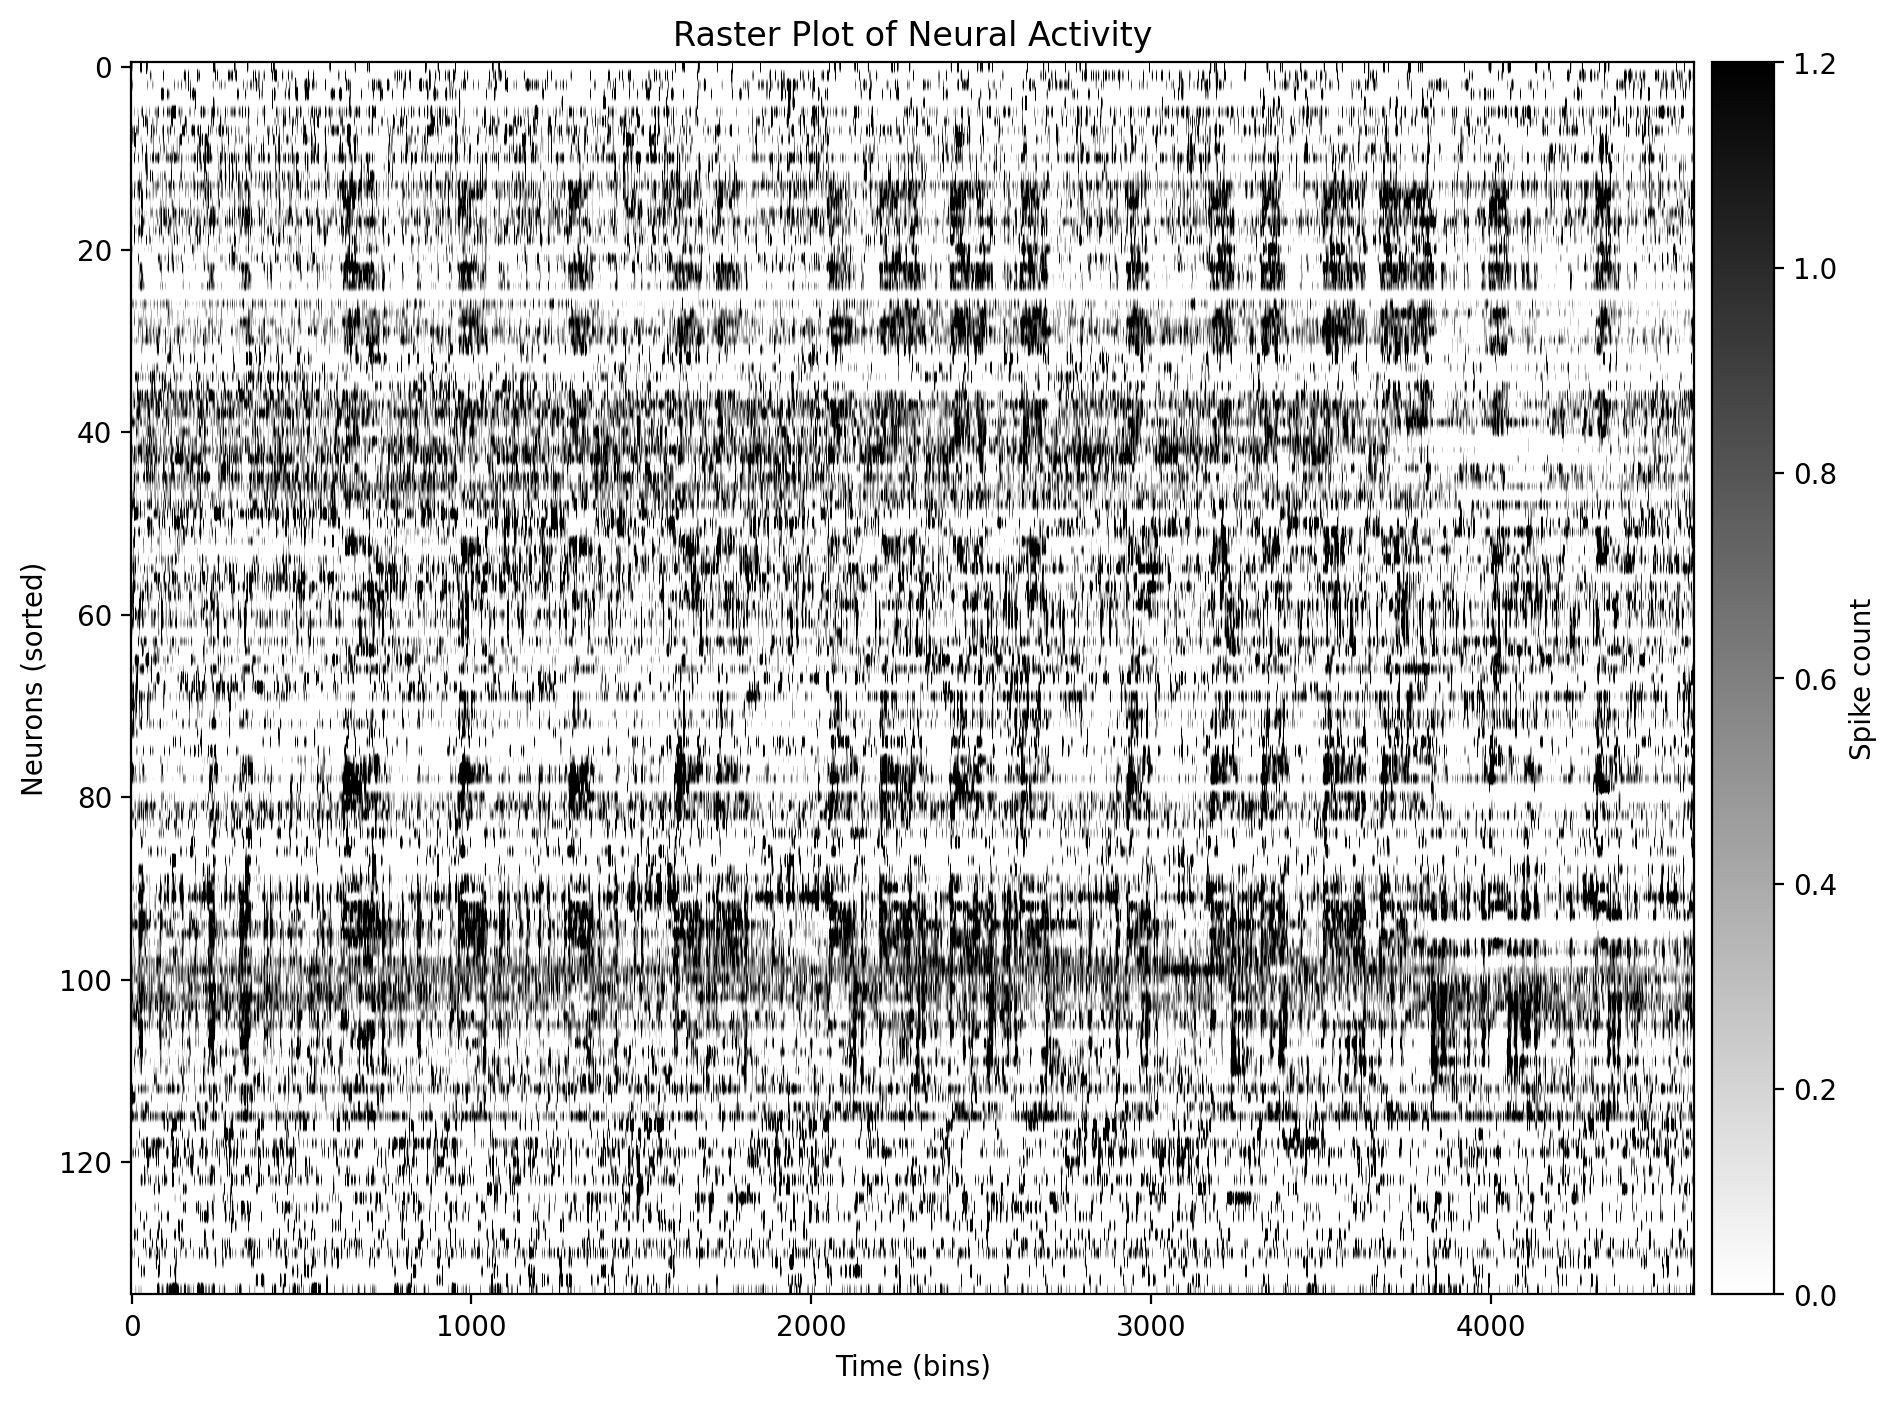

In [ ]:
xmin = 22000

xmax = 28000

fig, ax = plt.subplots(figsize=(12, 8), dpi=200)

im = ax.imshow(spike_counts_zscored[isort, xmin:xmax], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
ax.set_xlabel("Time (bins)")
ax.set_ylabel("Neurons (sorted)")
ax.set_title("Raster Plot of Neural Activity")

cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('Spike count')

plt.show()

The mouse has been shown natural images three different times, in this plot we focused on the last display.

We can now focus on the single blocks

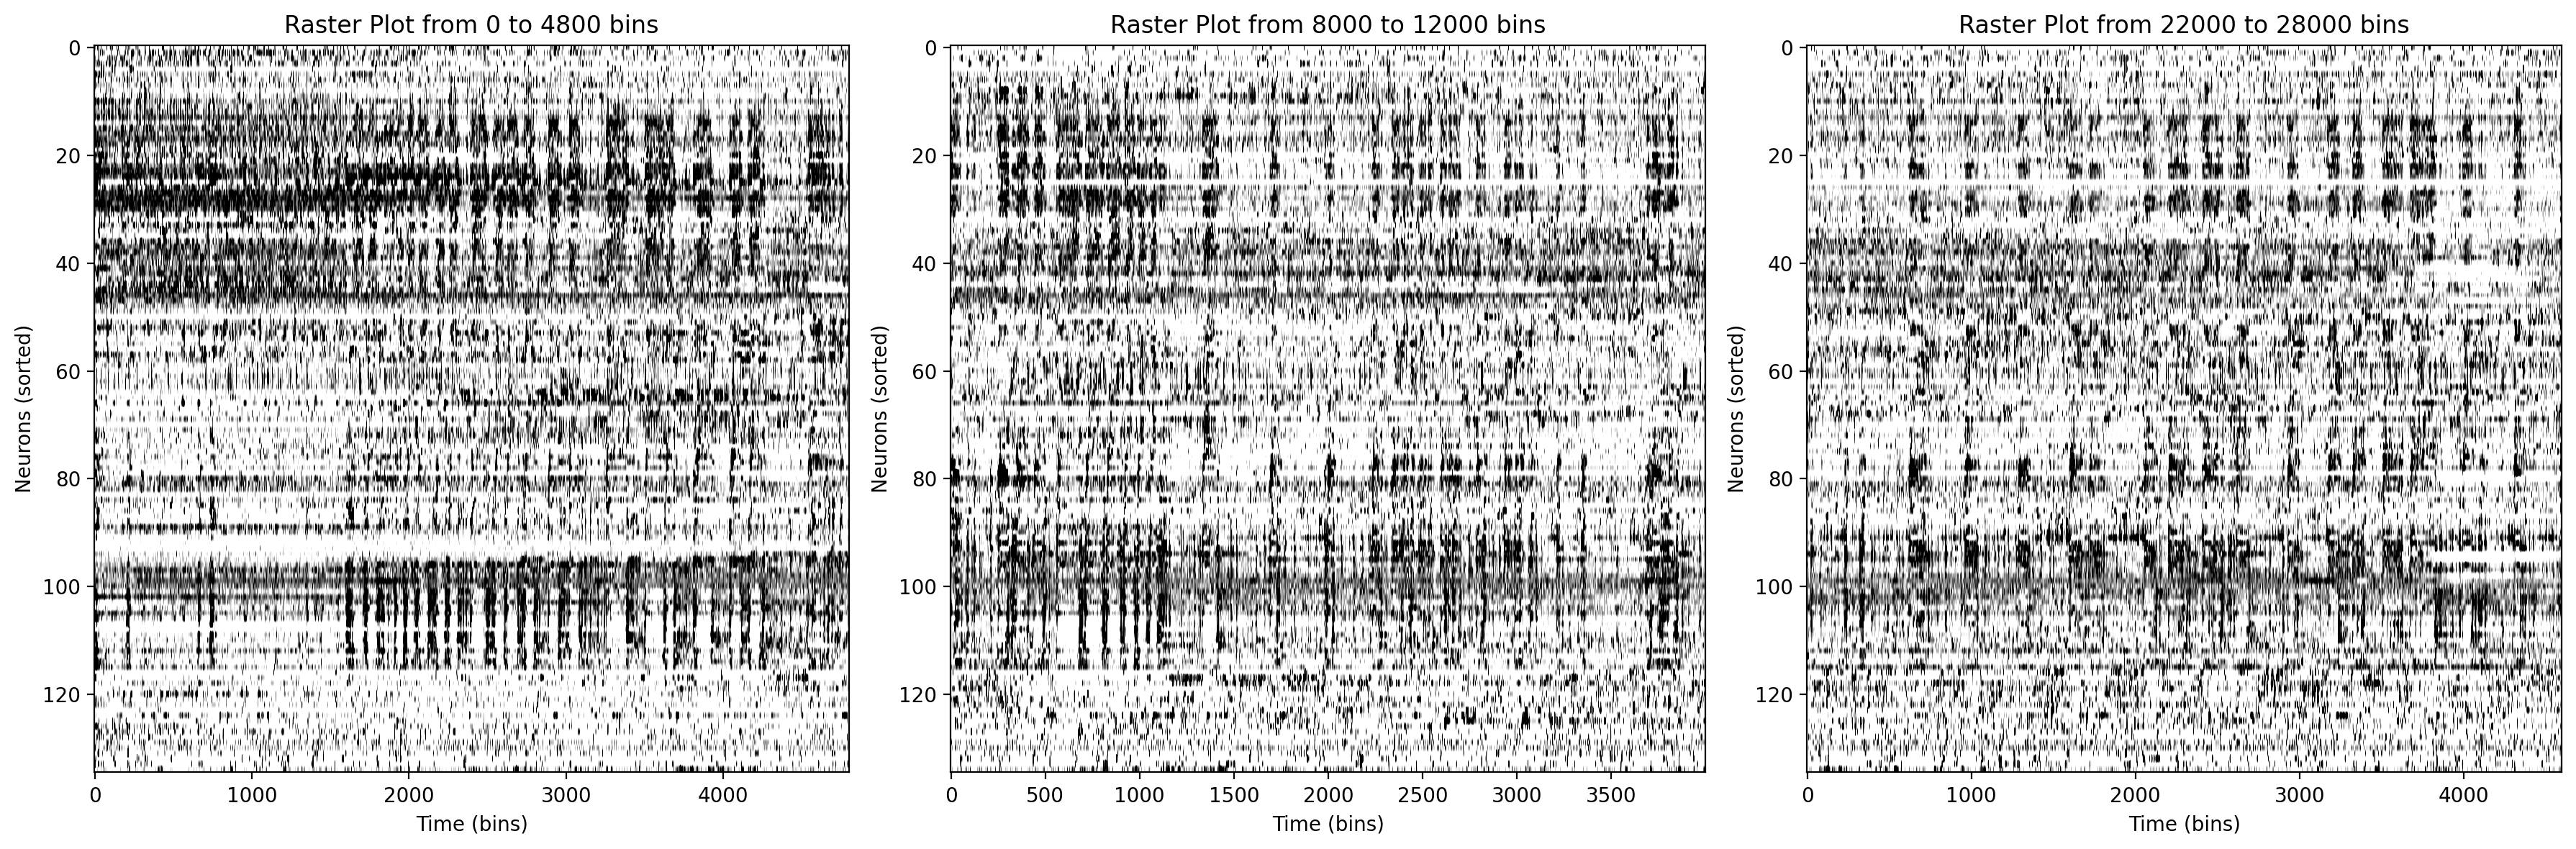

In [ ]:
# Define different xmin and xmax for each plot
xmin = [0, 8000, 22000]
xmax = [4800, 12000, 28000]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), dpi=200)

for i, ax in enumerate(axes.flat):
    # Plot each segment of the data
    im = ax.imshow(spike_counts_zscored[isort, xmin[i]:xmax[i]], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
    ax.set_xlabel("Time (bins)")
    ax.set_ylabel("Neurons (sorted)")
    ax.set_title(f"Raster Plot from {xmin[i]} to {xmax[i]} bins")


plt.tight_layout()
plt.show()


This plot shows that there are indeed some neurons which present a pattern behaviour in neural response, which indicates that there are good possibilities to select a neuron which will work well with our CNN. <br>
However let us note that there are neurons whose behaviour seems more noisy, hence selecting a good neurons is of utmost importance.

### **Covariance analysis:**

Importing the dataset, dropping useless data, transposing in order to have neurons as rows, columns as images

In [ ]:
data = pd.read_csv('dataset_for_agne_mean.csv')
data.drop(['frame', 'stimulus_presentation_id'], axis=1, inplace=True)
data = data.transpose()


Plotting the correlation matrix as a heatmap (transposing again in order to do it on neurons)

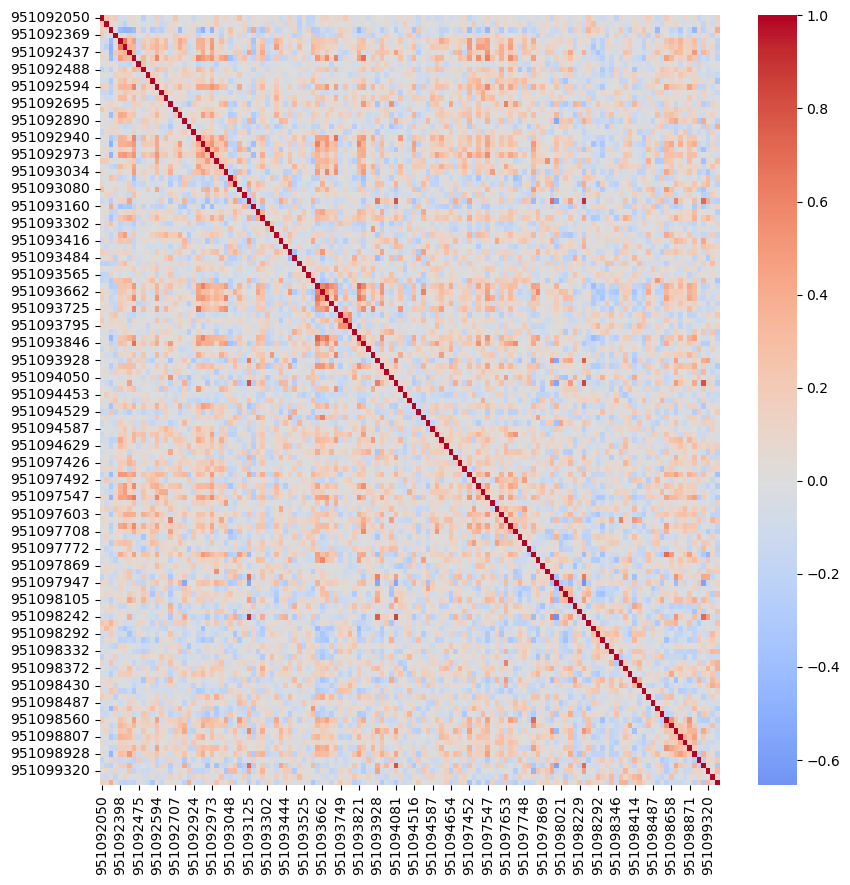

In [ ]:
correlation_matrix = data.transpose().corr()
# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))  # Adjust the size as needed
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.show()

No particular ambiguous correlation can be seen from this plot.

Now let's try to find for each neuron, the most correlated and the least correlated neuron.

In order to avoid problems, we fill the diagonal with NaN values, since for each neuron, the correlation with itself is always $1.0$

In [ ]:
np.fill_diagonal(correlation_matrix.values, np.nan)

In [ ]:
highest_correlations = correlation_matrix.max()
lowest_correlation = correlation_matrix.min()
most_correlated_neurons = correlation_matrix.idxmax()
least_correlated_neurons = correlation_matrix.idxmin()
results = pd.DataFrame({
    'Neuron': highest_correlations.index,
    'Highest Correlation': highest_correlations.values,
    'Most Correlated Neuron': most_correlated_neurons.values,
    'Lowest Correlation': lowest_correlation.values,
    'Least Correlated Neuron': least_correlated_neurons.values
})
print(results)

        Neuron  Highest Correlation Most Correlated Neuron  \
0    951092050             0.297214              951093080   
1    951092075             0.309912              951098279   
2    951092303             0.416028              951093160   
3    951092369             0.256688              951098530   
4    951092398             0.655551              951092410   
..         ...                  ...                    ...   
130  951099272             0.342826              951098414   
131  951099306             0.797598              951094081   
132  951099320             0.462756              951098242   
133  951099475             0.392041              951098430   
134  951099491             0.403545              951092303   

     Lowest Correlation Least Correlated Neuron  
0             -0.242279               951092488  
1             -0.239617               951093510  
2             -0.476467               951092949  
3             -0.240787               951093608  
4    

Let's see the highest correlated neurons by fixing a threshold of $0.7$.

In [ ]:
highly_correlated_neurons = results[results['Highest Correlation'] > 0.7]
highly_correlated_neurons

Neuron  Highest Correlation Most Correlated Neuron  \
32   951093125             0.905601              951098242   
47   951093608             0.736594              951093821   
56   951093821             0.736594              951093608   
60   951093928             0.750732              951098242   
64   951094081             0.848041              951098242   
94   951097826             0.703051              951098560   
105  951098242             0.905601              951093125   
123  951098560             0.703051              951097826   
131  951099306             0.797598              951094081   

     Lowest Correlation Least Correlated Neuron  
32            -0.553941               951097947  
47            -0.401066               951098279  
56            -0.429395               951092303  
60            -0.526685               951097947  
64            -0.548484               951097947  
94            -0.462980               951099320  
105           -0.654761               951097947  
123           -0.372543               951098303  
131           -0.576034               951097947

Let's see the lowest correlated neurons (i.e., negatively correlated)

In [ ]:
lowly_correlated_neurons = results[results['Lowest Correlation'] < -0.55]
lowly_correlated_neurons

Neuron  Highest Correlation Most Correlated Neuron  \
32   951093125             0.905601              951098242   
99   951097947             0.368022              951093608   
105  951098242             0.905601              951093125   
131  951099306             0.797598              951094081   

     Lowest Correlation Least Correlated Neuron  
32            -0.553941               951097947  
99            -0.654761               951098242  
105           -0.654761               951097947  
131           -0.576034               951097947

This result is weird, since by fixing a threshold of $-0.55$, we see that $4$ neurons are more negatively correlated than that, with the highest being $-0.654761$.

### **Isolation Forest for outlier detection**

In [ ]:

df = data.copy()
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(df.values)

anomalies = iso_forest.predict(df.values)

df['anomaly_score'] = iso_forest.decision_function(df.values)
df['is_anomaly'] = anomalies

anomalous_neurons = df[df['is_anomaly'] == -1]


### **Entropy and variance plots:**

In [ ]:
neuron_entropies = data.apply(lambda x: entropy(x.value_counts()), axis=1)


In [ ]:
# Dataset with anomaly values, entropy, correlation, and neuron with the most correlation
df_entropy_anomaly = pd.DataFrame({
    'Entropy' : neuron_entropies,
    'Anomaly' : df['is_anomaly'],
    'Highest reported correlation with another neuron': highest_correlations.values,
    'Most Correlated Neuron': most_correlated_neurons.values,
    'Variance': df.var(axis=1)
    })
df_entropy_anomaly.sort_values(by='Entropy', ascending=False, inplace=True)
df_entropy_anomaly.reset_index(inplace=True)
type_dict = {'index': int}
df_entropy_anomaly = df_entropy_anomaly.astype(type_dict)


In [ ]:
df_entropy_anomaly

index   Entropy  Anomaly  \
0    951093821  4.465900       -1   
1    951093608  4.435348       -1   
2    951092437  4.423117       -1   
3    951093283  4.400400       -1   
4    951098928  4.362596       -1   
..         ...       ...      ...   
130  951093810  2.104046        1   
131  951093510  2.061717        1   
132  951098317  2.045806        1   
133  951098372  2.014949        1   
134  951094036  1.533163        1   

     Highest reported correlation with another neuron Most Correlated Neuron  \
0                                            0.736594              951093608   
1                                            0.736594              951093821   
2                                            0.515452              951097547   
3                                            0.414326              951092437   
4                                            0.503125              951092437   
..                                                ...                    ...   
130                                          0.384974              951094050   
131                                          0.344498              951094573   
132                                          0.299732              951093510   
133                                          0.397437              951093283   
134                                          0.339248              951099306   

     Variance  
0    2.694286  
1    2.418180  
2    1.912515  
3    1.576702  
4    1.434995  
..        ...  
130  0.011959  
131  0.012383  
132  0.009211  
133  0.009025  
134  0.014631  

[135 rows x 6 columns]

In [ ]:
df_entropy_anomaly['Anomaly'].value_counts()

 1    116
-1     19
Name: Anomaly, dtype: int64

In [ ]:
df_entropy_anomaly.head(20)[df_entropy_anomaly['Anomaly']==-1].shape

/var/folders/_2/p0xm13rx0yq8v664xb_zz8tc0000gn/T/ipykernel_78987/1485505297.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_entropy_anomaly.head(20)[df_entropy_anomaly['Anomaly']==-1].shape


(14, 6)

In [ ]:
df_entropy_anomaly.sort_values(by='Variance', ascending=False).head(20)[df_entropy_anomaly['Anomaly']==-1].shape

/var/folders/_2/p0xm13rx0yq8v664xb_zz8tc0000gn/T/ipykernel_78987/2583719294.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_entropy_anomaly.sort_values(by='Variance', ascending=False).head(20)[df_entropy_anomaly['Anomaly']==-1].shape


(15, 6)

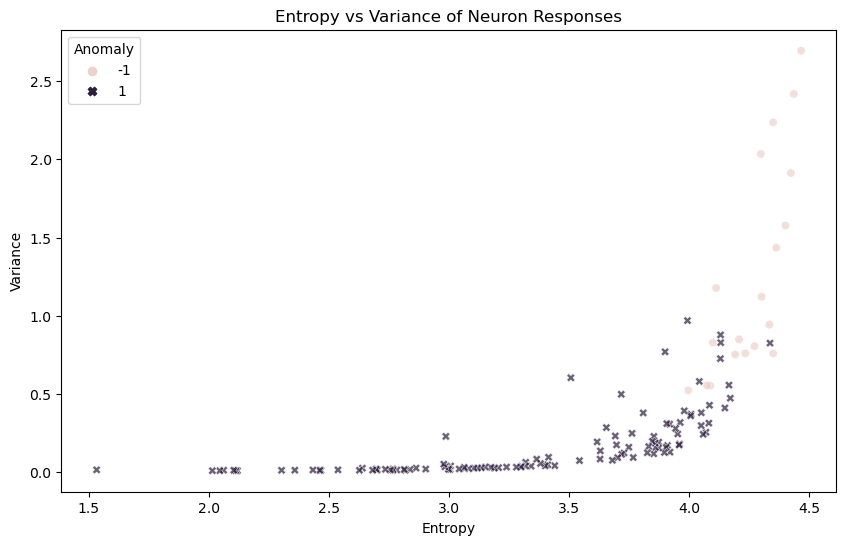

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_entropy_anomaly, x='Entropy', y='Variance', hue='Anomaly', style='Anomaly', alpha=0.7)
plt.title('Entropy vs Variance of Neuron Responses')
plt.xlabel('Entropy')
plt.ylabel('Variance')
plt.legend(title='Anomaly')
plt.show()


It's interesting to note that the isolation forest identified as anomalies neurons with high variance and high entropy.

### Oracle Correlation

In [ ]:

df_oracle = pd.read_csv('oracle_df.csv')


In [ ]:
df_oracle

trial_id  neuron_id  spike_count  image_id
0          51355  951092050            6        13
1          51355  951092075            2        13
2          51355  951092303            3        13
3          51355  951092369            2        13
4          51355  951092398            2        13
...          ...        ...          ...       ...
386344     68228  951098773            3       105
386345     68228  951098807            2       105
386346     68228  951098850            1       105
386347     68228  951098928            7       105
386348     68228  951099320            6       105

[386349 rows x 4 columns]

In [ ]:
def super_oracle(df):
    corr = dict()
    # Total number of images
    total_images = len(df['image_id'].unique())
    # Take a neuron
    for neuron_id in df['neuron_id'].unique():
        responses_list = []
        loom_list = []
        # Image counter
        image_counter = 0
        # Take an image which is shown to the neuron
        for image_id in df[(df['neuron_id'] == neuron_id)]['image_id'].unique():
            # Skip if there is only one trial for the image
            if len(df[(df['neuron_id'] == neuron_id) & (df['image_id'] == image_id)]['trial_id'].unique()) == 1:
                continue
            # Take a random trial for the image and neuron combination
            random_trial = random.choice(df[(df['neuron_id'] == neuron_id) & (df['image_id'] == image_id)]['trial_id'].unique())
            # Take the neuron response to the random trial
            response = df[(df['neuron_id'] == neuron_id) & (df['image_id'] == image_id) & (df['trial_id']==random_trial)]['spike_count'].values[0]
            # Compute the mean over all the other trials for the image
            loom_image = df[(df['neuron_id'] == neuron_id) & (df['image_id'] == image_id) & (df['trial_id']!=random_trial)]['spike_count'].values.mean()
            # Increment the image counter
            image_counter += 1
            # Append
            responses_list.append(response)
            loom_list.append(loom_image)
        # Compute the correlation between the leave-one-out-mean and the actual response for the neuron on that image
        try:
            correlation = pearsonr(responses_list, loom_list)[0]
        except:
            print(f"Neuron {neuron_id} has a problem")
            return neuron_id
        # Compute the image fraction
        image_fraction = image_counter / total_images
        corr[neuron_id] = correlation*image_fraction
    return pd.DataFrame.from_dict(corr, orient='index', columns=['super_oracle_correlation'])


In [ ]:
cor_super = super_oracle(df_oracle)
cor_super

super_oracle_correlation
951092050                 -0.115015
951092075                 -0.016209
951092303                  0.134748
951092369                  0.089028
951092398                  0.517139
...                             ...
951099272                  0.037873
951099475                 -0.004608
951098292                  0.133259
951094453                  0.268118
951098317                 -0.029089

[135 rows x 1 columns]

In [ ]:
cor_super.reset_index(inplace=True)
cor_super.sort_values(by='super_oracle_correlation', ascending=False, inplace=True)
cor_super

index  super_oracle_correlation
41   951094050                  0.651761
108  951093125                  0.579137
102  951098242                  0.578967
30   951093608                  0.569689
4    951092398                  0.517139
..         ...                       ...
7    951092488                 -0.093438
84   951093416                 -0.096325
106  951093020                 -0.105021
0    951092050                 -0.115015
28   951093565                 -0.163587

[135 rows x 2 columns]

In [ ]:
def average_super_oracle(df, iterations=10):
    rank_sums = {}  # Stores sum of ranks
    correlation_sums = {}  # Stores sum of correlations
    total_neuron_ids = df['neuron_id'].unique()

    # Initialize dictionaries
    for neuron_id in total_neuron_ids:
        rank_sums[neuron_id] = 0
        correlation_sums[neuron_id] = 0

    for _ in range(iterations):
        # Run the super_oracle function
        result_df = super_oracle(df)
        if type(result_df) != pd.DataFrame:
            print(f"Error in neuron {result_df}")
            return 0
        # Sort results by correlation in descending order and reset index
        sorted_df = result_df.sort_values(by='super_oracle_correlation', ascending=False).reset_index()

        # Record ranks and sum up correlations
        for index, row in sorted_df.iterrows():
            neuron_id = row['index']
            correlation = row['super_oracle_correlation']
            rank_sums[neuron_id] += index  # index is the rank
            correlation_sums[neuron_id] += correlation

    # Prepare to return the results
    average_ranks = {neuron_id: rank_sums[neuron_id] / iterations for neuron_id in total_neuron_ids}
    average_correlations = {neuron_id: correlation_sums[neuron_id] / iterations for neuron_id in total_neuron_ids}

    # Create DataFrame from the computed averages
    summary_df = pd.DataFrame.from_dict({
        'Average Rank': average_ranks,
        'Average Correlation': average_correlations
    })

    # Sort by average rank
    summary_df = summary_df.sort_values(by='Average Rank')

    return summary_df


In [ ]:
av = average_super_oracle(df_oracle, iterations=50)

In [ ]:
av

Average Rank  Average Correlation
951098242          1.44             0.602705
951093125          2.94             0.571175
951092798          5.70             0.489572
951093846          6.88             0.499745
951093821          7.84             0.452857
...                 ...                  ...
951098317        116.82            -0.043106
951093858        116.84            -0.044025
951093565        117.58            -0.081306
951093416        122.58            -0.082603
951092673        126.20            -0.085904

[135 rows x 2 columns]

In [ ]:
cor_super = av.copy()
cor_super.drop(columns=['Average Rank'], inplace=True)
cor_super.rename(columns={'Average Correlation': 'oracle_correlation'}, inplace=True)
cor_super.reset_index(inplace=True)
cor_super

index  oracle_correlation
0    951098242            0.602705
1    951093125            0.571175
2    951092798            0.489572
3    951093846            0.499745
4    951093821            0.452857
..         ...                 ...
130  951098317           -0.043106
131  951093858           -0.044025
132  951093565           -0.081306
133  951093416           -0.082603
134  951092673           -0.085904

[135 rows x 2 columns]

In [ ]:
df_entropy_anomaly_oracle = pd.merge(df_entropy_anomaly, cor_super, left_on='index', right_on='index')
df_entropy_anomaly_oracle.sort_values(by='oracle_correlation', ascending=False, inplace=True)
df_entropy_anomaly_oracle.reset_index(inplace=True)
df_entropy_anomaly_oracle.drop(['level_0'], axis=1, inplace=True)

In [ ]:
df_entropy_anomaly_oracle

index   Entropy  Anomaly  \
0    951098242  3.992573        1   
1    951093125  3.716815        1   
2    951093846  3.899434        1   
3    951092798  4.129662        1   
4    951093821  4.465900       -1   
..         ...       ...      ...   
130  951093858  2.302911        1   
131  951093565  3.004287        1   
132  951093416  3.134690        1   
133  951092673  2.696601        1   
134  951098372  2.014949        1   

     Highest reported correlation with another neuron Most Correlated Neuron  \
0                                            0.905601              951093125   
1                                            0.905601              951098242   
2                                            0.677264              951092450   
3                                            0.482546              951092949   
4                                            0.736594              951093608   
..                                                ...                    ...   
130                                          0.368254              951094654   
131                                          0.279689              951094050   
132                                          0.436531              951099306   
133                                          0.410253              951097530   
134                                          0.397437              951093283   

     Variance  oracle_correlation  
0    0.968955            0.602705  
1    0.497883            0.571175  
2    0.769341            0.499745  
3    0.725587            0.489572  
4    2.694286            0.452857  
..        ...                 ...  
130  0.011904           -0.044025  
131  0.016774           -0.081306  
132  0.027655           -0.082603  
133  0.019744           -0.085904  
134  0.009025                 NaN  

[135 rows x 7 columns]

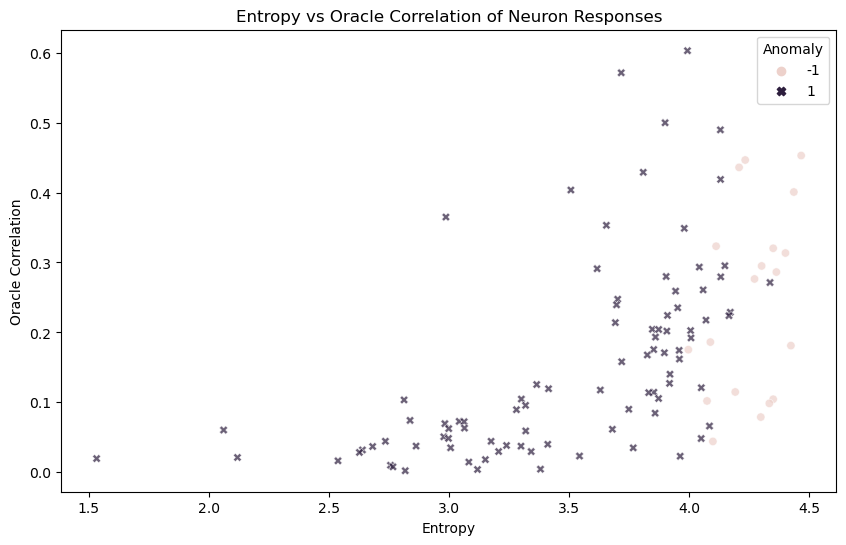

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_entropy_anomaly_oracle[df_entropy_anomaly_oracle['oracle_correlation']>0], x='Entropy', y='oracle_correlation', hue='Anomaly', style='Anomaly', alpha=0.7)
plt.title('Entropy vs Oracle Correlation of Neuron Responses')
plt.xlabel('Entropy')
plt.ylabel('Oracle Correlation')
plt.legend(title='Anomaly')
plt.show()

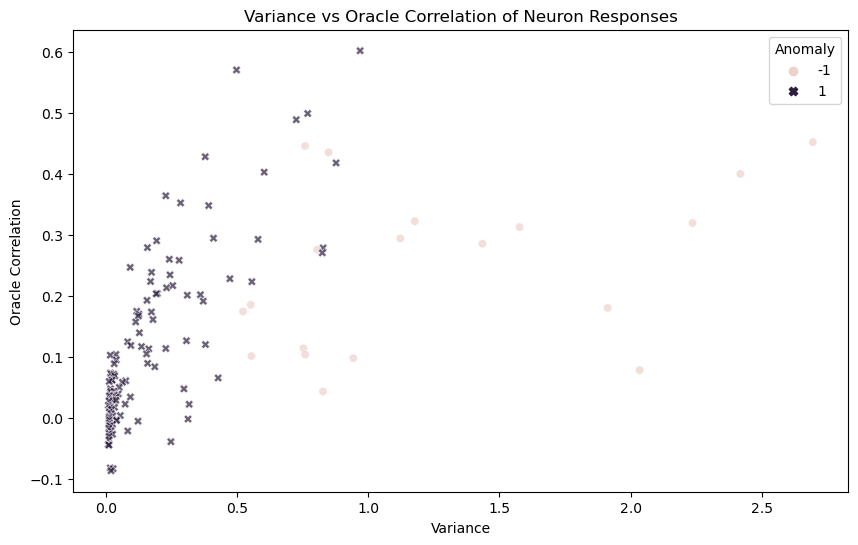

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_entropy_anomaly_oracle, x='Variance', y='oracle_correlation', hue='Anomaly', style='Anomaly', alpha=0.7)
plt.title('Variance vs Oracle Correlation of Neuron Responses')
plt.xlabel('Variance')
plt.ylabel('Oracle Correlation')
plt.legend(title='Anomaly')
plt.show()


In [ ]:
df_entropy_anomaly_oracle.sort_values(by='oracle_correlation', ascending= False)

index   Entropy  Anomaly  \
0    951098242  3.992573        1   
1    951093125  3.716815        1   
2    951093846  3.899434        1   
3    951092798  4.129662        1   
4    951093821  4.465900       -1   
..         ...       ...      ...   
130  951093858  2.302911        1   
131  951093565  3.004287        1   
132  951093416  3.134690        1   
133  951092673  2.696601        1   
134  951098372  2.014949        1   

     Highest reported correlation with another neuron Most Correlated Neuron  \
0                                            0.905601              951093125   
1                                            0.905601              951098242   
2                                            0.677264              951092450   
3                                            0.482546              951092949   
4                                            0.736594              951093608   
..                                                ...                    ...   
130                                          0.368254              951094654   
131                                          0.279689              951094050   
132                                          0.436531              951099306   
133                                          0.410253              951097530   
134                                          0.397437              951093283   

     Variance  oracle_correlation          Color  
0    0.968955            0.602705  Other Neurons  
1    0.497883            0.571175  Other Neurons  
2    0.769341            0.499745  Other Neurons  
3    0.725587            0.489572  Other Neurons  
4    2.694286            0.452857  Other Neurons  
..        ...                 ...            ...  
130  0.011904           -0.044025  Other Neurons  
131  0.016774           -0.081306  Other Neurons  
132  0.027655           -0.082603  Other Neurons  
133  0.019744           -0.085904  Other Neurons  
134  0.009025                 NaN  Other Neurons  

[135 rows x 8 columns]

In [ ]:
# Take neurons in the 60th percentile of the oracle correlation and 50th percentile of the variance
top_oracle_neurons = df_entropy_anomaly_oracle[(df_entropy_anomaly_oracle['oracle_correlation'] > df_entropy_anomaly_oracle['oracle_correlation'].quantile(0.6)) & (df_entropy_anomaly_oracle['Variance'] > df_entropy_anomaly_oracle['Variance'].quantile(0.5))]
top_oracle_neurons


index   Entropy  Anomaly  \
0   951098242  3.992573        1   
1   951093125  3.716815        1   
2   951093846  3.899434        1   
3   951092798  4.129662        1   
4   951093821  4.465900       -1   
5   951097947  4.232909       -1   
6   951094050  4.207487       -1   
7   951092398  3.808470        1   
8   951093928  4.130337        1   
9   951094081  3.507181        1   
10  951093608  4.435348       -1   
11  951093725  2.987012        1   
12  951093662  3.655037        1   
13  951099306  3.979247        1   
14  951092949  4.111789       -1   
15  951092940  4.349405       -1   
16  951093283  4.400400       -1   
17  951094516  4.148279        1   
18  951092973  4.301265       -1   
19  951092410  4.041892        1   
20  951093349  3.616517        1   
21  951098928  4.362596       -1   
22  951092924  3.903790        1   
23  951093472  4.131069        1   
24  951092961  4.271673       -1   
25  951093688  4.336214        1   
26  951097826  4.057939        1   
27  951098332  3.943135        1   
29  951097708  3.697292        1   
30  951092450  3.951929        1   
31  951092983  4.170997        1   
32  951093484  3.909350        1   
33  951097504  4.165286        1   
34  951097919  4.069588        1   
35  951097653  3.692260        1   
36  951097934  3.846258        1   
37  951099320  3.872860        1   
38  951098105  4.005780        1   
39  951098075  3.906645        1   
40  951097857  3.859465        1   
41  951098773  4.007322        1   
42  951092303  4.087908       -1   
43  951092437  4.423117       -1   
45  951097869  3.996161       -1   
46  951093069  3.957978        1   
47  951098265  3.896537        1   
49  951099491  3.959182        1   
51  951093160  3.919836        1   
52  951098560  3.918091        1   

    Highest reported correlation with another neuron Most Correlated Neuron  \
0                                           0.905601              951093125   
1                                           0.905601              951098242   
2                                           0.677264              951092450   
3                                           0.482546              951092949   
4                                           0.736594              951093608   
5                                           0.368022              951093608   
6                                           0.529467              951092695   
7                                           0.655551              951092410   
8                                           0.750732              951098242   
9                                           0.848041              951098242   
10                                          0.736594              951093821   
11                                          0.675827              951092940   
12                                          0.602763              951094559   
13                                          0.797598              951094081   
14                                          0.611074              951093608   
15                                          0.675827              951093725   
16                                          0.414326              951092437   
17                                          0.474654              951092949   
18                                          0.559254              951097547   
19                                          0.655551              951092398   
20                                          0.482599              951092410   
21                                          0.503125              951092437   
22                                          0.252571              951098384   
23                                          0.497556              951093662   
24                                          0.478252              951092983   
25                                          0.672685              951093608   
26                                          0.703051              95109856

In [ ]:
top_oracle_neurons.to_csv('top_oracle_neurons.csv', index=False)

In order to select the most informative neurons, we developed an oracle correlation method which analyses a neuron's response across different images. It compares a random response to the average response on other trials for the same image and penalises neurons with limited image data. \\

To ensure reliability, we developed a second function which runs this process 50 times (i.e., mean number of trials) and calculates average scores. \\
We focused on high-performing neurons with strong average oracle correlations (above 60th percentile) and high variance (above 50th percentile).

# **CNN Model**

In the following we define some auxiliary functions necessary for later computations of our Convolutional Neural Network. A more detailed description of the model can  be found below.

In [ ]:

def laplace():
    return np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]).astype(np.float32)[None, None, ...]

def positive(weight, cache=None):
    weight.data *= weight.data.ge(0).float()
    return cache

class Pyramid(nn.Module):
    _filter_dict = {
        'gauss5x5': np.float32([
            [0.003765, 0.015019, 0.023792, 0.015019, 0.003765],
            [0.015019, 0.059912, 0.094907, 0.059912, 0.015019],
            [0.023792, 0.094907, 0.150342, 0.094907, 0.023792],
            [0.015019, 0.059912, 0.094907, 0.059912, 0.015019],
            [0.003765, 0.015019, 0.023792, 0.015019, 0.003765]]),
        'gauss3x3': np.float32([
            [1 / 16, 1 / 8, 1 / 16],
            [1 / 8, 1 / 4, 1 / 8],
            [1 / 16, 1 / 8, 1 / 16]]
        ),
        'laplace5x5': np.outer(np.float32([1, 4, 6, 4, 1]), np.float32([1, 4, 6, 4, 1])) / 256,

    }

    def __init__(self, scale_n=4, type='gauss5x5', downsample=True, _skip_upsampling=False):
        """
        Setup Laplace image pyramid
        Args:
            scale_n: number of Laplace pyramid layers to construct
            type: type of Gaussian filter used in pyramid construction. Valid options are: 'gauss5x5', 'gauss3x3', and 'laplace5x5'
            downsample: whether to downsample the image in each layer. Defaults to True
        """
        super().__init__()
        self.type = type
        self.downsample = downsample
        self._skip_upsampling = _skip_upsampling
        h = self._filter_dict[type]
        self.register_buffer('filter', torch.from_numpy(h))
        self.scale_n = scale_n
        self._kern = h.shape[0]
        self._pad = self._kern // 2

    def lap_split(self, img):
        N, c, h, w = img.size()
        filter = self.filter.expand(c, 1, self._kern, self._kern).contiguous()

        # the necessary output padding depends on even/odd of the dimension
        output_padding = (h + 1) % 2, (w + 1) % 2

        smooth = F.conv2d(img, filter, padding=self._pad, groups=c)
        if self.downsample:
            lo = smooth[:, :, ::2, ::2]
            if self._skip_upsampling:
                # Technically incorrect implementation of the Laplace pyramid
                lo2 = smooth
            else:
                lo2 = 4 * F.conv_transpose2d(lo, filter, stride=2, padding=self._pad, output_padding=output_padding,
                                         groups=c)
        else:
            lo = lo2 = smooth

        hi = img - lo2

        return lo, hi

    def forward(self, img):
        levels = []
        for i in range(self.scale_n):
            img, hi = self.lap_split(img)
            levels.append(hi)
        levels.append(img)
        return levels

    def __repr__(self):
        return "Pyramid(scale_n={scale_n}, padding={_pad}, downsample={downsample}, type={type})".format(
            **self.__dict__)


class SpatialTransformerPyramid2d(nn.Module):
    def __init__(self, in_shape, outdims, scale_n=4, positive=False, bias=True,
                 init_range=.1, downsample=True, _skip_upsampling=False, type=None):
        super().__init__()
        self.in_shape = in_shape
        c, w, h = in_shape
        #print(f'c: {c}')
        self.outdims = outdims
        self.positive = positive
        self.gauss_pyramid = Pyramid(scale_n=scale_n, downsample=downsample, _skip_upsampling=_skip_upsampling, type=type)
        self.grid = Parameter(torch.Tensor(1, outdims, 1, 2))
        self.features = Parameter(torch.Tensor(1, c * (scale_n + 1), 1, outdims))
        #print(f'self.features first: {self.features.size()}')

        if bias:
            bias = Parameter(torch.Tensor(outdims))
            self.register_parameter('bias', bias)
        else:
            self.register_parameter('bias', None)
        self.init_range = init_range
        self.initialize()

    def initialize(self):
        self.grid.data.uniform_(-self.init_range, self.init_range)
        self.features.data.fill_(1 / self.in_shape[0])

        if self.bias is not None:
            self.bias.data.fill_(0)

    def group_sparsity(self, group_size):
        f = self.features.size(1)
        n = f // group_size
        ret = 0
        for chunk in range(0, f, group_size):
            ret = ret + (self.features[:, chunk:chunk + group_size, ...].pow(2).mean(1) + 1e-12).sqrt().mean() / n
        return ret

    def feature_l1(self, average=True):
        if average:
            return self.features.abs().mean()
        else:
            return self.features.abs().sum()

    def neuron_layer_power(self, x, neuron_id):
        if self.positive:
            positive(self.features)
        self.grid.data = torch.clamp(self.grid.data, -1, 1)
        N, c, w, h = x.size()
        m = self.gauss_pyramid.scale_n + 1
        feat = self.features.view(1, m * c, self.outdims)
        print(f'self.features second: {feat.size()}')
        y = torch.cat(self.gauss_pyramid(x), dim=1)
        y = (y * feat[:, :, neuron_id, None, None]).sum(1)
        return y.pow(2).mean()

    def forward(self, x, shift=None):
        if self.positive:
            positive(self.features)
        self.grid.data = torch.clamp(self.grid.data, -1, 1)
        N, c, w, h = x.size()
        m = self.gauss_pyramid.scale_n + 1
        feat = self.features.view(1, m * c, self.outdims)

        if shift is None:
            grid = self.grid.expand(N, self.outdims, 1, 2)
        else:
            grid = self.grid.expand(N, self.outdims, 1, 2) + shift[:, None, None, :]

        pools = [F.grid_sample(xx, grid, align_corners=True) for xx in self.gauss_pyramid(x)]
        y = torch.cat(pools, dim=1).squeeze(-1)
        y = (y * feat).sum(1).view(N, self.outdims)

        if self.bias is not None:
            y = y + self.bias
        return y

    def __repr__(self):
        c, w, h = self.in_shape
        r = self.__class__.__name__ + \
            ' (' + '{} x {} x {}'.format(c, w, h) + ' -> ' + str(self.outdims) + ')'
        if self.bias is not None:
            r += ' with bias'

        for ch in self.children():
            r += '  -> ' + ch.__repr__() + '\n'
        return r



class Laplace(nn.Module):
    """
    Laplace filter for a stack of data.
    """

    def __init__(self, padding=0):
        super().__init__()
        self._padding = padding
        self.register_buffer('filter', torch.from_numpy(laplace()))

    def forward(self, x):
        return F.conv2d(x, self.filter, padding=self._padding, bias=None)

class LaplaceL2(nn.Module):
    """
    Laplace regularizer for a 2D convolutional layer.
    """

    def __init__(self, padding=0):
        super().__init__()
        self.laplace = Laplace(padding=padding)

    def forward(self, x, weights=None):
        ic, oc, k1, k2 = x.size()
        if weights is None:
            weights = 1.0
        return (self.laplace(x.view(ic * oc, 1, k1, k2)).view(ic, oc, k1, k2).pow(2) * weights).mean() / 2

class Core:
    def initialize(self):
        #log.info('Not initializing anything')
        pass

    def __repr__(self):
        s = super().__repr__()
        s += ' [{} regularizers: '.format(self.__class__.__name__)
        ret = []
        for attr in filter(lambda x: 'gamma' in x or 'skip' in x, dir(self)):
            ret.append('{} = {}'.format(attr, getattr(self, attr)))
        return s + '|'.join(ret) + ']\n'


class Core2d(Core):
    def initialize(self, cuda=False):
        self.apply(self.init_conv)
        if cuda:
            self = self.cuda()

    @staticmethod
    def init_conv(m):
      if type(m) == nn.Conv2d:
          nn.init.xavier_normal_(m.weight.data)
          if m.bias is not None:
             nn.init.constant_(m.bias.data, 0)
    #def init_conv(m):
     #   if isinstance(m, nn.Conv2d):
      #    nn.init.xavier_normal_(m.weight.data)
       #   if m.bias is not None:
        #    m.bias.fill_(0)

# ---------------------- Identity Core ---------------------------
class IdentityCore(nn.Module, Core2d):
    def __init__(self, **kwargs):
        #log.info('Ignoring input {} when creating {}'.format(repr(kwargs), self.__class__.__name__))
        super().__init__()

    def forward(self, x):
        return x

    def regularizer(self):
        return 0.0

# ---------------------- Conv2d Cores with Pooling -----------------------------


class Stacked2dCore_pooling(Core2d, nn.Module):
  def __init__(self, input_channels, hidden_channels, input_kern, hidden_kern, pooling, hidden_pooling, layers=3,
                 gamma_hidden=0, gamma_input=0., skip=0, final_nonlinearity=True, bias=False, skip_nonlin=False,
                 momentum=0.1, pad_input=True, batch_norm=True, laplace_padding=0, laplace_weights_fn=None,**kwargs):
    #log.info('Ignoring input {} when creating {}'.format(repr(kwargs), self._class.name_))
    super().__init__()

    if skip_nonlin:
      print('Skip non-linearity')
    self._input_weights_regularizer = LaplaceL2(padding=laplace_padding)

    self.layers = layers
    self.gamma_input = gamma_input
    self.gamma_hidden = gamma_hidden
    self.input_channels = input_channels
    self.hidden_channels = hidden_channels

    self.skip = skip

    self.features = nn.Sequential()
    self.pooling = pooling
    self.hidden_pooling = hidden_pooling
        # --- first layer
    layer = OrderedDict()
    layer['conv'] = \
            nn.Conv2d(input_channels, hidden_channels, input_kern,
                      padding=input_kern // 2 if pad_input else 0, bias=bias)
    layer['pool'] = nn.AvgPool2d(pooling)
    if batch_norm:
      layer['norm'] = nn.BatchNorm2d(hidden_channels, momentum=momentum)
    if (not skip_nonlin) and (layers > 1 or final_nonlinearity):
      layer['nonlin'] = nn.ELU(inplace=True)
    self.features.add_module('layer0', nn.Sequential(layer))

        # --- other layers
    for l in range(1, self.layers):
       layer = OrderedDict()
       layer['conv'] = \
           nn.Conv2d(hidden_channels if not skip > 1 else min(skip, l) * hidden_channels,
                     hidden_channels, hidden_kern,
                     padding=hidden_kern // 2, bias=bias)
       layer['pool'] = nn.AvgPool2d(hidden_pooling)
       if batch_norm:
           layer['norm'] = nn.BatchNorm2d(hidden_channels, momentum=momentum)
       if (not skip_nonlin) and (final_nonlinearity or l < self.layers - 1):
           layer['nonlin'] = nn.ELU(inplace=True)
       self.features.add_module('layer{}'.format(l), nn.Sequential(layer))
    self.apply(self.init_conv)

    if laplace_weights_fn is not None:
        _, _, h, w = self.features[0].conv.weight.size()
        dist_grid = torch.sqrt(torch.linspace(-1, 1, h)[:, None].pow(2) + torch.linspace(-1, 1, w).pow(2))
        self.register_buffer('laplace_weights', laplace_weights_fn(dist_grid))
    else:
        self.laplace_weights = None


  def forward(self, input_):
    ret = []
    for l, feat in enumerate(self.features):
      do_skip = l >= 1 and self.skip > 1
      input_ = feat(input_ if not do_skip else torch.cat(ret[-min(self.skip, l):], dim=1))
      ret.append(input_)
    return torch.cat(ret, dim=1)
  def laplace(self):
    return self._input_weights_regularizer(self.features[0].conv.weight, weights=self.laplace_weights)
  def group_sparsity(self):
    ret = 0
    for l in range(1, self.layers):
      ret = ret + self.features[l].conv.weight.pow(2).sum(3, keepdim=True).sum(2, keepdim=True).sqrt().mean()
    return ret / ((self.layers - 1) if self.layers > 1 else 1)
  def regularizer(self):
    return self.group_sparsity() * self.gamma_hidden + self.gamma_input * self.laplace()
  @property
  def outchannels(self):
    return len(self.features) * self.hidden_channels




#951092594

class CustomDataset(Dataset):
    def __init__(self, root_dir, dataframe, transform=None, target_size=(60, 96)):
        self.root_dir = root_dir
        self.dataframe = dataframe
        self.transform = transform
        self.target_size = target_size

        # Filter out non-image files and hidden files
        self.image_names = [f for f in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, f)) and not f.startswith('.')]
        self.responses = self.dataframe['951092075'].tolist()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.root_dir, image_name)

        # Load image
        image = Image.open(image_path).convert('L')  # Convert to grayscale

        # Resize image
        image = Resize(self.target_size)(image)

        # Apply additional transformations
        if self.transform:
            image = self.transform(image)

        # Get corresponding neuronal response
        response = self.responses[idx]

        return image, response






class CustomCNN_2_pooling(nn.Module):
  def __init__(self, input_channels):
    super(CustomCNN_2_pooling, self).__init__()

    # Define the CNN core with three layers
    self.conv_core = Stacked2dCore_pooling(input_channels= input_channels,
                                        hidden_channels=64,
                                        input_kern=4,
                                        hidden_kern=3,
                                        pooling = 2,
                                        hidden_pooling=1,
                                        layers=3,
                                        gamma_hidden=0.1,
                                        gamma_input=0.1,
                                        skip=1,
                                        final_nonlinearity=True,
                                        bias=False,
                                        skip_nonlin=False,
                                        momentum=0.1,
                                        pad_input=True,
                                        batch_norm=True,
                                        laplace_padding=0, stride = 3)

    # Calculate the number of output channels from the CNN core
    self.outchannels = self.conv_core.outchannels
    #self.readout = CustomReadout(self.outchannels)

    self.readout = SpatialTransformerPyramid2d(in_shape=(self.outchannels, 96, 60),
                                                           type = 'gauss5x5',
                                                           scale_n=3,
                                                          # outchannels = 256,
                                                           outdims=1,
                                                           positive=True)
  def forward(self, x):
    # Forward pass through the convolutional core
    features = self.conv_core(x)
    outputs = self.readout(features)
    return outputs





# **CNN Structure**



The fundamental architecture comprises 3 blocks, each followed by a neuron-specialized readout layer. More specifically, the structure is as follows.


### **Core block**

1. **Convolutional Layer**: Utilizes a kernel size tailored to match available Gabor filters, facilitating an effective comparison between stimuli.

2. **Batch Normalization Layer**: Essential for preventing overfitting by standardizing and normalizing the inputs of each layer.

3. **Non-linearity Activation**: Implemented using the Exponential Linear Unit (ELU) function, defined as:

\begin{align}
        \text{ELU}(x) = \left\{
        \begin{array}{cl}
        x & x \geq 0 \\
        e^x-1 & x < 0.
        \end{array}
        \right.
    \end{align}


4. **Pooling Layer (for the first block)**: Positioned before the non-linearity activation to expedite computations and enhance performance. Pooling layers help in downsampling feature maps, thereby reducing dimensionality while retaining essential information.

This structured approach optimizes the network's performance by enabling effective feature extraction, regularization, and computational efficiency.

### **Readout Layer**

The readout layer synthesizes the features extracted by the CNN into a single scalar representing the average spike activity of a neuron. This layer is modeled as an affine transformation of the features, followed by a non-linearity. To ensure the output remains positive, the activation function employed is $ELU(x)+1$.

For further insights into the entire network structure, including the readout layer, refer to the following paper:

*Walker, E.Y., Sinz, F.H., Cobos, E. et al. "Inception loops discover what excites neurons most using deep predictive models." *Nature Neuroscience*, vol. 22, pp. 2060–2065, 2019.*

This approach encapsulates the essence of the network's functionality, providing a mechanism for interpreting neuron excitations through deep predictive models.

---


# **Most Excitatory Inputs (MEIs):**

In this section, we proceed by generating the Most Excitatory Input for the selected neurons.
We will exploit the convolutional neural network defined and trained in the previous section so that, by identifying which features of the stimuli (such as edges, colors, orientations, movements, etc.) trigger the highest firing rates, it is now possible can construct a stimulus that combines these features in a way that is most likely to activate the neuron maximally.

### **Setup: Dataset and Model**

We decided to set up a new dataset by merging the training and the test set of the CNN. We now have a dataset that has the 118 natural grayscale images as indices and the neurons of the session as columns. The entries are torch tensors of reduced dimension (1, 60, 96) and encode the images' pixel intensity.

In [ ]:
# Here I import a dataset containing all 118 natural scenes of a
mei_dir = '/content/drive/MyDrive/MEI testing/Images_final'
dataframe_mei = pd.read_csv('/content/drive/MyDrive/Neuroscience Project/dataset_for_agne_mean.csv')
dataframe_mei.sort_values(by='frame', inplace=True)
dataframe_mei.set_index('frame', inplace=True, drop=True)
dataframe_mei = dataframe_mei.drop(dataframe_mei.index[0])

# Here I let the images be reduced in 60X96 format
mei_dataset = CustomDataset(mei_dir, dataframe_mei, transform=transforms.ToTensor())

Below, we provide an example of one of the images or our dataset. It is possible to notice that it is more blurred than the original, and that the edges are less sharp than a high-resolution picture.

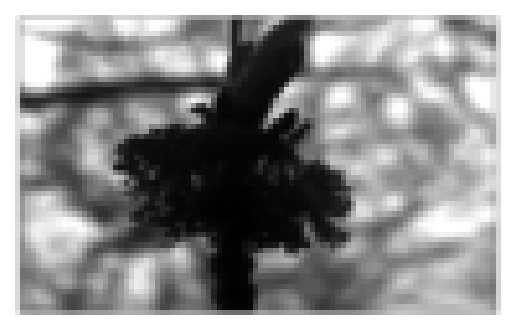

In [ ]:
a = np.random.randint(0,117)
plt.imshow(mei_dataset[a][0].squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

Then, we load the model we stored in the following checkpoint file and set it to evaluation mode. \\
This corresponds to the model used to predict the responses for the neuron $\text{neuron_id} = '951097947'$, which is associated with the highest recorded accuracy value ($59$%).

In [ ]:
neuron_id = '951097947'

In [ ]:
# Define the path to the checkpoint file
model_path = '/content/drive/MyDrive/Neuroscience Project/checkpoints_final/checkpoint_epoch_951097947_size_gabor_kernel_59_accuracy.pth'

# Initialize the model
model = CustomCNN_2_pooling(1)  # Replace YourModelClass with the class name of your model

# Load the checkpoint
checkpoint = torch.load(model_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Optional: If you have an optimizer saved in the checkpoint and want to load it
# optimizer = YourOptimizerClass(model.parameters(), lr=your_learning_rate)  # Replace YourOptimizerClass with the class name of your optimizer
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Access other saved information
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_correlation = checkpoint['train_correlation']
val_correlation = checkpoint['val_correlation']

# Optionally, you can set the model to evaluation mode if needed
model.eval()

#### **Target contrast:**
Given the extended dataset we constructed, we now compute the average contrast $C^*$ (defined as the mean standard deviation) of all images. This variable  represents the target constant value of the MEI that will be generated, and will be used later on in the optimization to construct the penalty term of our loss function to optimize. \\
The main purpose of $C^*$ is to help adjust the contrast of the MEI at each iteration, in order produce a stimulus that keeps roughly the same characteristics as the dataset the CNN was trained on.

In [ ]:
# Initialization
c_star_std = 0

for i in range(len(mei_dataset)):
  #std of images
  std = torch.std(mei_dataset[i][0])
  c_star_std += std
# Average over all images
c_star_std /= len(mei_dataset)
# Put in into number format
c_star_std = c_star_std.item()

print(f"Mean standard deviation for our dataset is {c_star_std}")

Mean standard deviation for our dataset is 0.2655758261680603


### **MEI computation: The Algorithm**

In order to proceed with the generation of the MEI, we follow the steps of the algorithm:
1. Initialization: generate a Gaussian white noise img: $I_{MEI} = wn$
2. Compute gradients of MEI image: $grads = grad(I_{MEI})$
3. Perform a Fast Fourier Transform of grads: $fftgrad = fftsmooth(grads)$
4. Perform Gradient Ascent step: $I_{MEI}$ += $α \cdot fftgrad$
5. Make sure that the image is scaled in preferred interval: $I_{MEI}$ = $scale(I_{MEI})$

Repeat 2-5 for a preferred number of steps.\
Moreover, in order to keep the image's contrast aligned with respect to the average standard deviation of the natural scenes, we performed a  L1-regularization in the loss function: $ \textit{L} = r - λ⋅|c^* - c| $

### **Utils:**
We proceed by defininig the functions that will be needed for the actual computation: \\
$\text{grad}$: extracts the gradient from the $\text{backward()}$ pass of the CNN; \\
$\text{fft_smooth}$: performs a Fast Fourier transform, which helps in suppressing high frequency noises making the variables smoother for optimization; \\
$\text{scale}$: used here to scale gradients in the range $[0,1]$.

In [ ]:
# Grad computation function
def grad(model, img, i, r, stds):

    # Set the model to evaluation mode (no weights update)
    model.eval()
    # Contrast regularization parameter
    param = 2

    # Ensure image is the correct dimension
    img = img.view(1, 1, 60, 96)
    # Ensure tracking of gradients for the input image
    img.requires_grad_(True)

    # Forward pass through the model
    outputs = model(img)
    output = outputs.sum()

    # Save statistics
    std = torch.std(img)
    r.append(output)
    stds.append(std)

    # Regularize with respect to the computed c_star_std
    output -= param * torch.abs(torch.tensor(c_star_std) - std)

    # Print to see how the optimization is working
    if i % 10 == 0:
      print(f"Loss to minimize is {output} in step {i} with std {std}")

    # Clear previous gradients
    model.zero_grad()

    # Backpropagate to compute gradients w.r.t. input images
    output.backward()

    # Get the gradients of the image and reshape to [H, W]
    image_gradients = img.grad.detach().cpu().squeeze()
    return image_gradients, output #output [60,96] torch tensor



# Define fast fourier transform
def fft_smooth(grad, factor= 1/4):

    if factor == 0:
        return grad.numpy()  # Directly return the numpy array if no smoothing is to be applied

    # Ensure grad is a torch tensor
    if isinstance(grad, np.ndarray):
        grad = torch.from_numpy(grad).float()

    # Obtain dimensions
    h, w = grad.shape

    # Adjust tw for the reduced dimensionality of the rFFT output
    tw = torch.arange(0, w//2 + 1).float()
    th = torch.arange(0, h).float()

    # Compute the frequency weights
    # Distance from origin in frequency space, avoiding division by zero
    radius = torch.sqrt(th[:, None]**2 + tw[None, :]**2) + 1e-8
    t = 1 / radius**factor

    # Normalize the filter to preserve overall energy
    F = t / t.mean()

    # Compute the FFT of the gradient
    grad_fft = torch.fft.rfftn(grad, dim=(0, 1))

    # Apply the filter in the frequency domain
    filtered_fft = grad_fft * F

    # Compute the inverse FFT to transform back to the spatial domain
    filtered_grad = torch.fft.irfftn(filtered_fft, s=(h, w), dim=(0, 1))

    # Convert back to numpy for any subsequent processing
    return filtered_grad.numpy() #[60,96] numpy array



# Scale in a preferred interval [c,d]

def scale(img, c = 0,d = 1):
  # Quantities for scaling
  a = img.min()
  b = img.max()
  # Scaling formula
  sc_matrix =  c + (img - a) * (d - c) / (b - a)
  return np.array(sc_matrix) # [60,96] numpy array

### **1. Gaussian white noise**

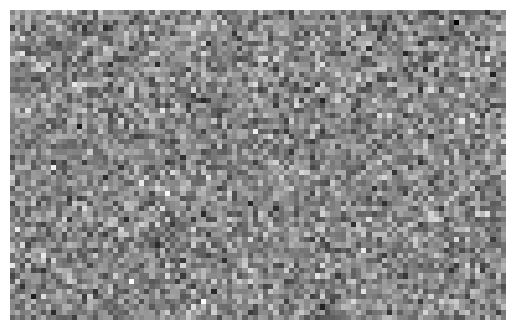

In [ ]:
# Generate white Gaussian noise image
# scaled between [0, 1]
height, width = 60,96

wn = scale(np.random.normal(0, 1, size = (height, width)), 0, 1)

#display
plt.imshow(wn, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Here we transform the white noise into a tensor [1,1,60,96] readable by our model
scaled_data_tensor = torch.unsqueeze(torch.tensor(normal_data), dim=0).float()
img_tens = torch.unsqueeze(scaled_data_tensor, 0)
print(img_tens.size())

torch.Size([1, 1, 60, 96])


### **2.- 5. Iterative process:**

**Function containing everything needed to compute MEIs**

The hyperparameters we aim to fine-tune to achieve an optimal performance are:
- $\text{steps}$: number of iterations
- $\text{sigma}$: the parameter that is responsible for the initial amount of blurring. It will be iteratively reduced during the process until it reaches a value of $0.01$
- $C^*$: the target contrast (computed before and set as a default variable);
- $\alpha$: the parameter responsible for regulating the step size of each gradient ascent step. It was set as $0.01$ by rule of thumb.

In [ ]:
def generate_mei(wn, steps, sigma, dataset= mei_dataset, alpha=0.1, c_star= c_star_std):

  # Here we transform the whote noise into a tensor readable by our model
  scaled_data_tensor = torch.unsqueeze(torch.tensor(wn), dim=0).float()
  img_tens = torch.unsqueeze(scaled_data_tensor, 0)

  # Some statistics:
  # Some Statistics
  r,stds = [],[]

  for i in range(1, steps+1):

    # Compute the gradients for the imput image
    gradients, output = grad(model, img_tens, i, r, stds)
    response = output.item()

    # Transform the input image as a numpy object for smoother computation
    img_tens = img_tens.squeeze().detach().numpy()
    # Fourier Transform to smooth gradients
    fft_grad = fft_smooth(gradients)
    # Do Gradient Ascent step
    img_tens += alpha*fft_grad
    # Perform a Gaussian Blur and reduce sigma at each step
    sigma = sigma + ((0.001 - sigma)*i)/steps
    img_tens = torch.tensor(scipy.ndimage.gaussian_filter(img_tens,sigma,order = 0))
    # Scale to 0-1
    img_tens = scale(img_tens,0,1)
    # Bring it to tensor in order to re-initialize the for loop
    img_tens = torch.unsqueeze(torch.unsqueeze(torch.tensor(img_tens), dim=0).float(), 0)

  final_mei = img_tens.squeeze().numpy()
  #final_response = response
  return final_mei, r, stds

Now we can call
```
mei_59, r_59, std_59 = generate_mei(neuron_id)
```
and visualize the MEI.

In [ ]:
mei_59, r_59, std_59 = generate_mei(wn, steps=1000, sigma=7)

Loss to minimize is 4.375064849853516 in step 10 with std 0.2515137791633606
Loss to minimize is 4.308009624481201 in step 20 with std 0.269641637802124
Loss to minimize is 4.273122310638428 in step 30 with std 0.2788967788219452
Loss to minimize is 4.265032768249512 in step 40 with std 0.2836967408657074
Loss to minimize is 4.283144474029541 in step 50 with std 0.2857617139816284
Loss to minimize is 4.344533920288086 in step 60 with std 0.28649529814720154
Loss to minimize is 4.481871128082275 in step 70 with std 0.2868041396141052
Loss to minimize is 4.77593469619751 in step 80 with std 0.28716763854026794
Loss to minimize is 5.128570079803467 in step 90 with std 0.2877623736858368
Loss to minimize is 5.434421539306641 in step 100 with std 0.2883569896221161
Loss to minimize is 5.6400580406188965 in step 110 with std 0.28283339738845825
Loss to minimize is 5.604672908782959 in step 120 with std 0.26160919666290283
Loss to minimize is 5.5008931159973145 in step 130 with std 0.24287052

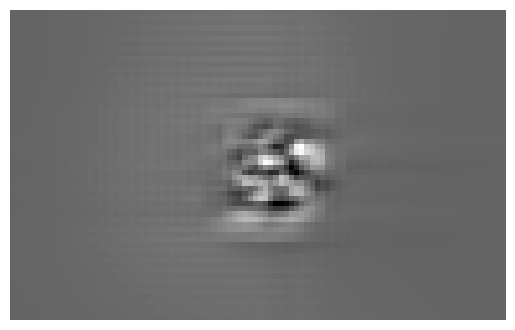

In [ ]:
plt.imshow(mei_59, cmap='gray')
plt.axis('off')
plt.show()

#### **Statistics Analysis:**

As we analyse how the predicted neuronal response to the MEI and its contrast evolve in time, we observe two insightful opposite behaviors, suggesting that the optimization is affecting the image during the process of MEI generation: the neuronal response that is predicted by the CNN at each iteration on the refined stimulus is increasing, and the standard deviation of the resulting image is decreasing.
##### **Increasing neuronal response:**
This behavior indicates that the MEI is becoming more effective at exciting the neuron. This increase is expected because the optimization process is specifically designed to adjust the image to maximize the neuron's response. As MEIs are designed based on the unique response characteristics of the targeted neuron, the MEI evolves in such a way that it aligns more closely with the neuron's receptive field or the features that the neuron is most responsive to. Over iterations, the image is refined to enhance the features that maximize activation, thereby increasing its effectiveness in stimulating the neuron. \\

##### **Decreasing Standard Deviation:**
The decreasing standard deviation in the image during this process can be attributed to several factors:

1. *Convergence to Specific Features:* As the optimization focuses on enhancing specific features that maximally activate the neuron, the image becomes more focused or 'purified' towards the most stimulating features. This results in a reduction of the overall variability (standard deviation), since the image loses its randomness and becomes more uniform.

2. *Reduction of Noise:* In the initial stages, the image may contain a lot of random noise (since it starts from white noise). As the optimization progresses, it selectively enhances certain features over others, often reducing the noise or less relevant features, leading to a decrease in the overall standard deviation of pixel intensities.

3. *Normalization and Scaling Effects:* Depending on how the image is being processed during the optimization (e.g., scaling, normalization) the process might naturally reduce the spread of pixel intensity values.

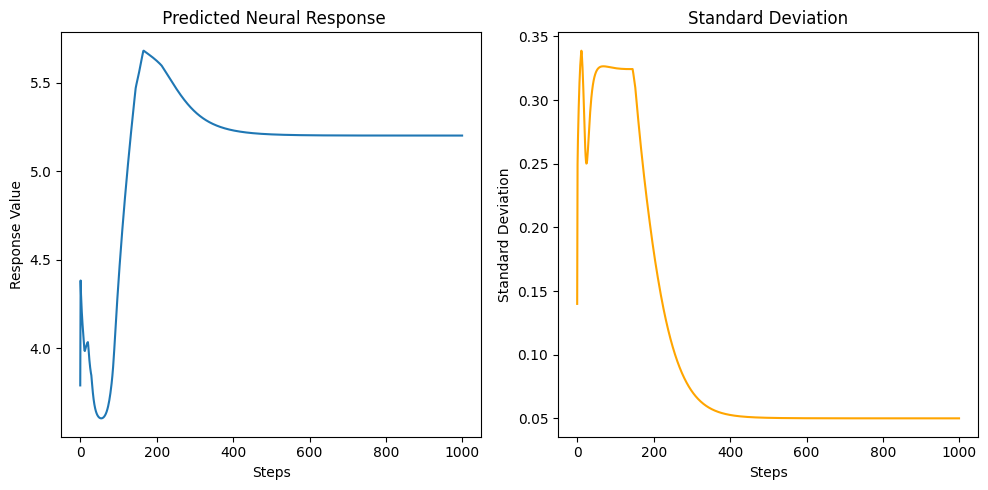

In [ ]:
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot neural response
axs[0].plot(np.array([t.item() for t in r_59]), label='Neural Response')
axs[0].set_title(' Predicted Neural Response')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Response Value')

# Plot standard deviation
axs[1].plot(np.array([t.item() for t in std_59]), label='Standard Deviation', color='orange')
axs[1].set_title('Standard Deviation')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Standard Deviation')

# Add a legend
#axs[0].legend()
#axs[1].legend()

# Show the plots
plt.tight_layout()
plt.savefig("Statistics.png")
plt.show()


In [ ]:
print(f'The maximal neuronal response is {r_59[-1]}')
print(f'The standard deviation of the MEI is {std_59[-1]}')

The maximal neuronal response is 5.203412055969238
The standard deviation of the MEI is 0.05023481696844101


##### **Further Considerations on Standard Deviation:**

While the increase in the neuronal response is a desired outcome indicating successful optimization towards an MEI, the decrease in standard deviation should be considered carefully:

- *Loss of Detail:* If the standard deviation decreases significantly, it could imply that the image is losing detail. This might not necessarily be negative but is something to be aware of, especially if one may want to use this result to estimate the full spectrum of stimuli that affect the neuron.

- *Overfitting to Neuron:* There's a possibility that the MEI is overfitting to the neuron's characteristics in the current setup, especially if the decrease in standard deviation suggests a loss of complexity in the image.

In order to ensure a successful result, it might be needed to compute the contrast of a masked version of the image, where only the circular area of the MEI is considered.

### **Invariance with respect to initial input**:
As it was previously stated, Most Excitatory Inputs are designed based on the unique response characteristics of the targeted neurons, combining features that maximize their activation. \\
One may wonder whether the MEI depends on the image which the optimization procedure is initialized on. Therefore, we repeat the process feeding a black image (all pixels have intensity zero) to the function.

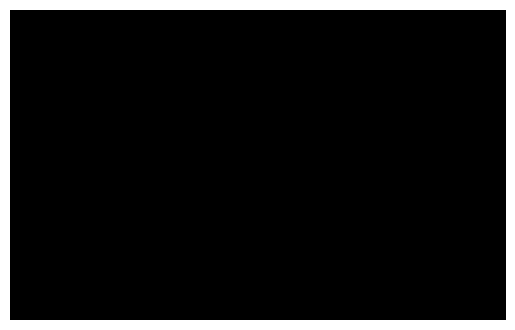

In [ ]:
bl = np.zeros((60,96))
plt.imshow(bl, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
mei_check, r_check, std_check = generate_mei(bl, steps=1000, sigma=7)

Predicted regularized response in step 10 is: 3.4271063804626465 with std 0.30462244153022766
Predicted regularized response in step 20 is: 3.278251886367798 with std 0.3353641629219055
Predicted regularized response in step 30 is: 3.264526844024658 with std 0.3388451039791107
Predicted regularized response in step 40 is: 3.2978897094726562 with std 0.3380120098590851
Predicted regularized response in step 50 is: 3.3261239528656006 with std 0.33806490898132324
Predicted regularized response in step 60 is: 3.362445116043091 with std 0.3379369378089905
Predicted regularized response in step 70 is: 3.4305732250213623 with std 0.33763590455055237
Predicted regularized response in step 80 is: 3.5854854583740234 with std 0.3372311294078827
Predicted regularized response in step 90 is: 3.7948713302612305 with std 0.3368215560913086
Predicted regularized response in step 100 is: 4.000244140625 with std 0.3364415764808655
Predicted regularized response in step 110 is: 4.246574401855469 with std

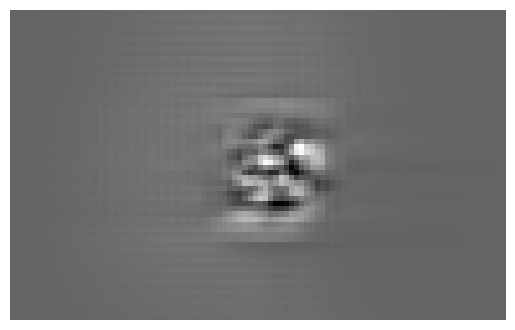

In [ ]:
plt.imshow(mei_check, cmap='gray')
plt.axis('off')
plt.show()

In essence, MEIs are not random or natural stimuli but are instead crafted or optimized through computational methods to include the most excitatory features recognizable by the neuron.

# **Gabor Filters**
##### **Preliminary discussion**:
As was mentioned earlier, one of the primary goals of creating MEIs is to understand what specific visual or sensory characteristics a neuron or group of neurons is most sensitive to. The conclusions for such a query could be provided by in-vivo validation; however, this approach is not feasible with the experimental setup we are working with. \\

Comparing Most Excitatory Inputs (MEIs) with Gabor filters can indeed serve as a useful proxy for in vivo validation of neural models, especially in the context of visual neuroscience. \\

## **Generate most responsive gabors:**
**Gabor filters** are mathematical models that mimic the response of neurons in the mammalian visual cortex to specific visual stimuli, particularly those involving spatial frequency and orientation selectivity. \\

### **Preliminary analysis:**

We start with a dataset that follows the same setup as the pd.DataFrames used in the previous sections: we take the gabor filters' IDs as the DataFrame indices, and the neurons' IDs as the columns. This table allows to visualize the range of the spike counts triggered by the gabor filters for our selected neuron.

In [ ]:
firing_rate_gabors = pd.read_csv('/content/drive/MyDrive/Neuroscience Project/dataset_for_agne_gabor.csv')

# make it more readable
firing_rate_gabors = firing_rate_gabors.set_index(firing_rate_gabors['stimulus_presentation_id']).drop('stimulus_presentation_id', axis=1)
firing_rate_gabors.head()

951092050  951092075  951092303  951092369  \
stimulus_presentation_id                                               
1                                 1          4          5          2   
2                                 1          2          1          2   
3                                 2          6          2          2   
4                                 1          3          2          3   
5                                 3          4          1          3   

                          951092398  951092410  951092437  951092450  \
stimulus_presentation_id                                               
1                                 1          4          0          1   
2                                 0          4          0          0   
3                                 0          8          3          0   
4                                 1          1          2          1   
5                                 0          1         15          3   

                          951092475  951092488  ...  951098773  951098807  \
stimulus_presentation_id                        ...                         
1                                 1          5  ...          8          1   
2                                 2          1  ...         10          2   
3                                 1          1  ...          5          1   
4                                 0          7  ...          6          2   
5                                 2          0  ...          6          4   

                          951098850  951098871  951098928  951099272  \
stimulus_presentation_id                                               
1                                 1          3          4          0   
2                                 2          7          5          0   
3                                 0          6          5          0   
4                                 0          3          0          0   
5                                 1          5          3          0   

                          951099306  951099320  951099475  951099491  
stimulus_presentation_id                                              
1                                 2          0          0          0  
2                                 3          0          0          0  
3                                 2          1          0          0  
4                                 2          1          0          0  
5                                 0          0          0          0  

[5 rows x 135 columns]

In [ ]:
firing_rate_gabors[neuron_id].min(), firing_rate_gabors[neuron_id].max()

(0, 8)

Using the DataFrame $\text{gabors_meta}$, it is possible to access the metadata about the Gabor filters in the same session of the Allen SDK Dataset.

In [ ]:
gabors_meta = pd.read_csv('/content/drive/MyDrive/Neuroscience Project/gabors_meta.unknown', sep = '\t')
gabors_meta = gabors_meta.set_index('stimulus_presentation_id')   # more readable:
gabors_meta.head()

stimulus_block  start_time  stop_time stimulus_name  \
stimulus_presentation_id                                                        
1                                    0.0   84.942787  85.176306        gabors   
2                                    0.0   85.176306  85.426505        gabors   
3                                    0.0   85.426505  85.676704        gabors   
4                                    0.0   85.676704  85.926904        gabors   
5                                    0.0   85.926904  86.177122        gabors   

                          x_position          size  \
stimulus_presentation_id                             
1                               20.0  [20.0, 20.0]   
2                               30.0  [20.0, 20.0]   
3                               40.0  [20.0, 20.0]   
4                                0.0  [20.0, 20.0]   
5                              -40.0  [20.0, 20.0]   

                                                   phase  spatial_frequency  \
stimulus_presentation_id                                                      
1                         [3644.93333333, 3644.93333333]               0.08   
2                         [3644.93333333, 3644.93333333]               0.08   
3                         [3644.93333333, 3644.93333333]               0.08   
4                         [3644.93333333, 3644.93333333]               0.08   
5                         [3644.93333333, 3644.93333333]               0.08   

                          orientation  temporal_frequency  contrast  \
stimulus_presentation_id                                              
1                                90.0                 4.0       0.8   
2                                 0.0                 4.0       0.8   
3                                45.0                 4.0       0.8   
4                                90.0                 4.0       0.8   
5                                45.0                 4.0       0.8   

                          y_position  duration  stimulus_condition_id  
stimulus_presentation_id                                               
1                              -10.0  0.233519                      1  
2                               40.0  0.250199                      2  
3                              -30.0  0.250199                      3  
4                              -40.0  0.250199                      4  
5                               10.0  0.250218                      5

First, we observe that all gabors are presented to the mouse for a duration of approximately $0.25$ seconds, and that all gabors have roughly the same features. \\


In [ ]:
gabors_meta['duration'].value_counts().index

Index([0.2502017433212131, 0.2502182566787496, 0.2502157566788128,
       0.2502067433212005, 0.2502132566787622, 0.2501967433212257,
       0.2502042433212637, 0.2502207566788001, 0.2502157566786991,
       0.2502182566788065,
       ...
       0.2502017433213837, 0.2502257566789012, 0.2502092433212084,
       0.2502232566786802, 0.2502142433212952, 0.2501992304961362,
       0.2501942433212605, 0.2501917433212668, 0.2502132566787765,
       0.2501917433208973],
      dtype='float64', name='duration', length=230)

In [ ]:
print('Sizes:', set(gabors_meta['size']))
print('Phases:', set(gabors_meta['phase']))
print('Spatial Frequencies:', set(gabors_meta['spatial_frequency']))
print('Temporal Frequencies:', set(gabors_meta['temporal_frequency']))
print('Contrast:', set(gabors_meta['contrast']))

Sizes: {'[20.0, 20.0]'}
Phases: {'[3644.93333333, 3644.93333333]'}
Spatial Frequencies: {0.08}
Temporal Frequencies: {4.0}
Contrast: {0.8}


The only parameters that differs across gabors are the orientation and position of the filter.
However, we opted to exclude the position parameter when generating the most responsive gabor, as it was deemed irrelevant for the purpose of comparison with MEIs. Given the process used to generate MEIs, all filters are centered in our images. Consequently, we maintained the Gabor filters centered and focused solely on orientation. We observed only three balanced classes of orientations: $\{0°, 45°, 90°\}$.

In [ ]:
gabors_meta['orientation'].value_counts()

orientation
90.0    1215
0.0     1215
45.0    1215
Name: count, dtype: int64

### **Gabor extraction:**

We now proceed with the extraction of the gabor filter that maximizes the chosen neuron's activation. \\
We notice that, in case there exists more than a unique gabor that maximally excites the neuron, it can be useful to merge the first $k$ gabors that trigger the highest spike count. This approach not only leverages the collective excitatory potential of these top-performing Gabors but also addresses the constraints imposed by a limited parameter space. \\

Therefore, the decision to merge these Gabors is driven by the need to introduce greater variability among the generated Gabors.

We define the following functions that allow to reconstruct the most excitatory gabor by taking the average of the $k=3$ gabors that trigger the highest firing rate:

In [ ]:
## CREATE GABORS

def create_gabor(sz, phase, wavelength, orientation, sigma,
                 dy, dx):
    """ Create a gabor patch (sinusoidal + gaussian).

    Arguments:
        height (int): Height of the image in pixels.
        width (int): Width of the image in pixels.
        phase (float): Angle at which to start the sinusoid in degrees.
        wavelength (float): Wavelength of the sinusoid (1 / spatial frequency) in pixels.
        orientation (float): Counterclockwise rotation to apply (0 is horizontal) in
            degrees.
        sigma (float): Sigma of the gaussian mask used in pixels
        dy (float): Amount of translation in y (positive moves down) in pixels/height.
        dx (float): Amount of translation in x (positive moves right) in pixels/height.

    Returns:
        Array of height x width shape with the required gabor.
    """

    # Compute image size to avoid translation or rotation producing black spaces
    padding = max(height, width)
    imheight = height + 2 * padding
    imwidth = width + 2 * padding
    # we could have diff pad sizes per dimension = max(dim_size, sqrt((h/2)^2 + (w/2)^2))
    # but this simplifies the code for just a bit of inefficiency

    # Create sinusoid with right wavelength and phase
    start_sample = phase
    step_size = 360 / wavelength
    samples = start_sample + step_size * np.arange(imheight)
    samples = np.mod(samples, 360)  # in degrees
    rad_samples = samples * (np.pi / 180)  # radians
    sin = np.sin(rad_samples)

    # Create Gabor by stacking the sinusoid along the cols
    gabor = np.tile(sin, (imwidth, 1)).T

    # Rotate around center
    gabor = ndimage.rotate(gabor, orientation, reshape=False)

    # Apply gaussian mask, its is normalized to take values in [0,1]
    gaussy = signal.windows.gaussian(imheight, std=sigma)
    gaussx = signal.windows.gaussian(imwidth, std=sigma)
    mask = np.outer(gaussy, gaussx)
    gabor = gabor * mask

    # Translate (this is only approximate but it should be good enough)
    if abs(dx) > 1 or abs(dy) > 1:
        raise ValueError('Please express translations as factors of the height/width,'
                         'i.e, a number in interval [-1, 1] ')
    dy = int(dy * height)  # int is the approximation
    dx = int(dx * width)
    gabor = gabor[padding - dy: -padding - dy, padding - dx: -padding - dx]

    if gabor.shape != (height, width):
        raise ValueError('Dimensions of gabor do not match desired dimensions.')

    return gabor.astype(np.float32)

In [ ]:
def most_exc_gabors(neuron_id, df = firing_rate_gabors):

    neuron_spks = df[neuron_id]

    # Sort the indices based on the firing rates in descending order
    sorted_indices = sorted(neuron_spks.index, key=lambda i: neuron_spks[i], reverse=True)

    # Select the top 3 indices with the highest firing rates
    top_3_indices = sorted_indices[:3]

    return top_3_indices

In [ ]:
## Computes the mean gabor as a numpy array

def mean_gabor(neuron_id, gab_meta = gabors_meta):
  gabors_okay = gabors_meta.T.iloc[:,most_exc_gabors(neuron_id)].T
  gabors_okay_ids = list(gabors_okay.index)

  gabors = []
  for i in gabors_okay_ids:
    gabors.append(create_gabor(sz=(60,96), phase=3644.93333333, wavelength=np.pi, orientation=gabors_okay.loc[i,'orientation'], sigma=5,
                   dy=0, dx=0))

  gabors_combined = np.stack(gabors, axis=0)

  # Compute the mean across the arrays along axis 0
  mean_gabors = np.mean(gabors_combined, axis=0)

  # Scale in range [0, 1]
  mean_gabors = scale(mean_gabors, 0, 1)

  return mean_gabors


We can now visualize the gabor:

In [ ]:
gabor_59 = mean_gabor(neuron_id)

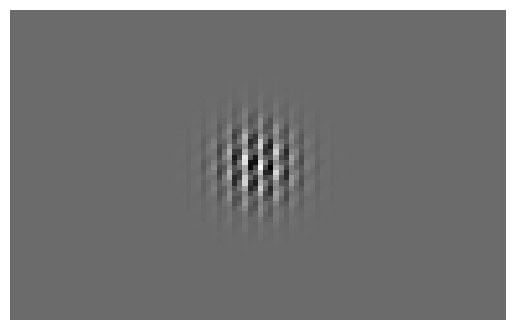

In [ ]:
plt.imshow(gabor_59, cmap='gray')
plt.axis('off')
plt.show()

# **Comparative Analysis:**
### *Validating MEIs*
We now dispose of the setup needed to proceed with a qualitative analysis about the difference between the CNN-based extracted MEIs and the Gabors from our dataset.

**Similarities in response:** \\
If the MEIs generated through computational models resemble the patterns produced by Gabor filters, this similarity can validate their biological plausibility. \\

In the primary visual cortex, particularly in areas like V1, many neurons have receptive fields that respond optimally to specific orientations and spatial frequencies. These characteristics make Gabor patches ideal for studying and activating these neurons.
However it is important to note that our study is limited to the fact that we cannot validate our findings through an in-vivo analysis, implying that MEIs and Gabor's response cannot be directly compared. Relevant research indicates that MEIs drive a higher response than Gabor patches for neurons in the V1 cortex. \\

Where differences arise, it may indicate more complex or nonlinear processing than what Gabor filters can account for. Such differences could suggest additional layers of complexity in neural responses, especially in neurons with higher-order or more specialized functions. \\

**Validation of Neural Coding:** By demonstrating that MEIs activate neurons in ways similar to Gabor filters, it is possible to  infer that the computational model correctly identifies the types of stimuli to which real neurons are most responsive.

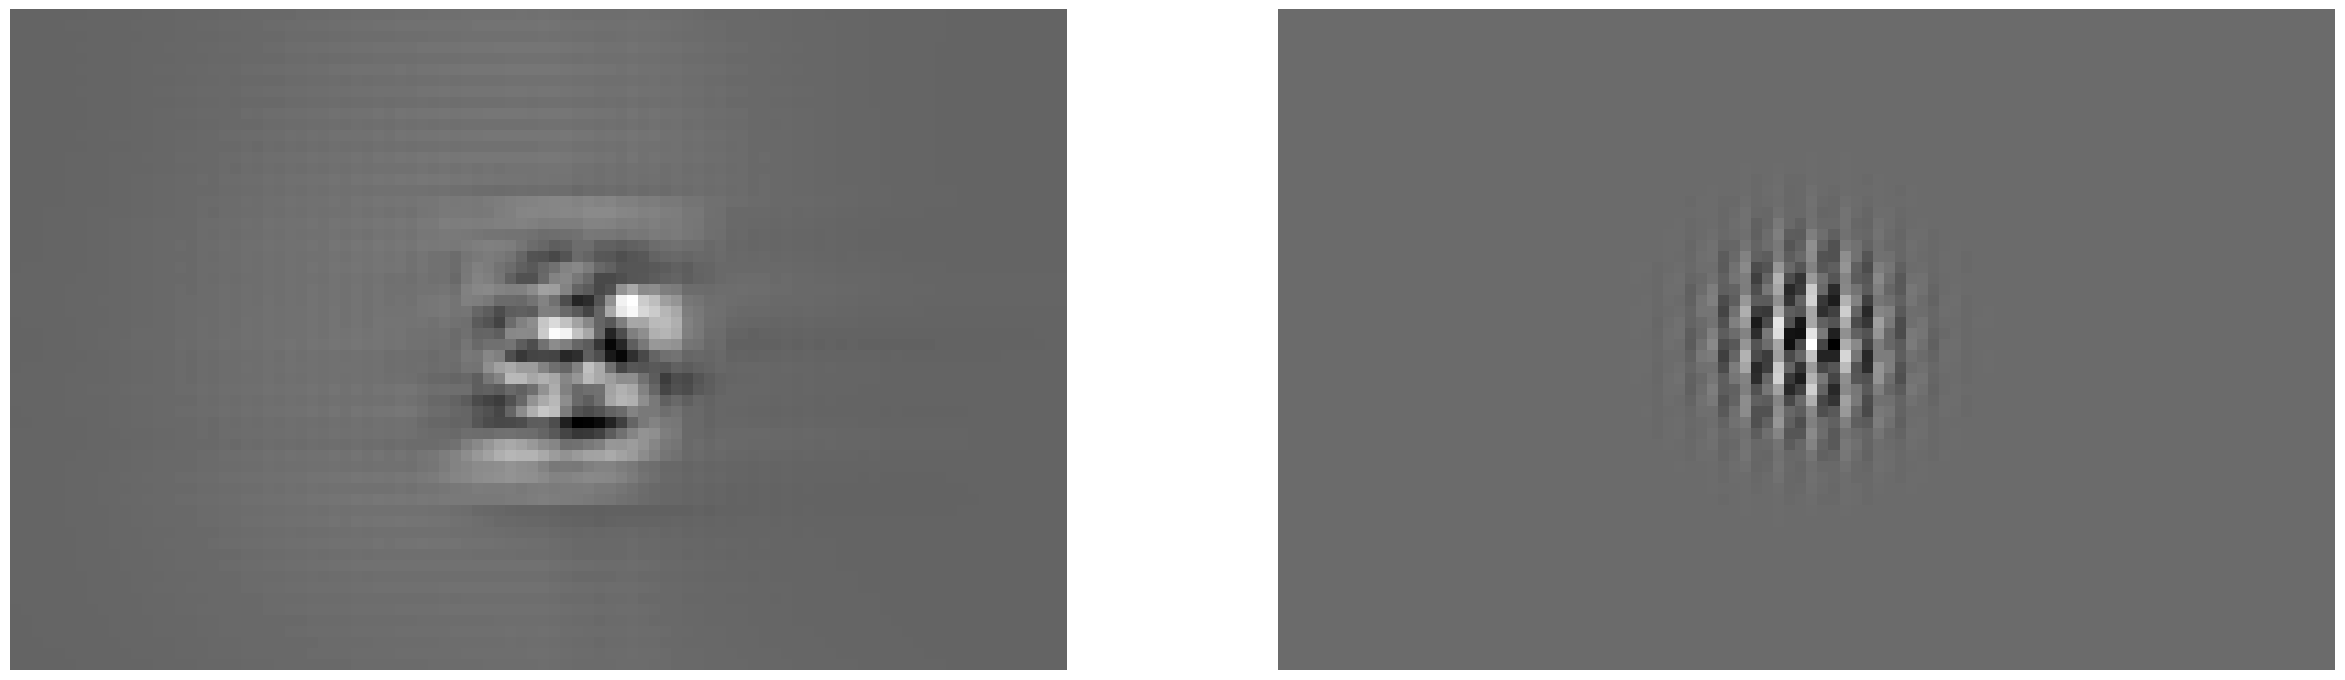

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(30,10))
axarr[0].imshow(mei_59, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(gabor_59, cmap = 'gray');
axarr[1].axis('off')
plt.show()

## **Initial Observations:**
When comparing Most Excitatory Inputs generated by deep learning models to traditional Gabor filters, it is not uncommon to find differences in appearance. While Gabor filters are specifically designed to model the spatial sensitivities of V1 simple cells, MEIs are derived from complex optimization processes that may incorporate a broader set of neuronal behaviors and response characteristics, including but not limited to orientation, spatial frequency, and phase. \\


##### **Orientation:**
The images exhibit a subtle diagonal orientation; however, neither distinctly specifies a particular direction. This slight diagonal alignment suggests that the neuron is potentially responsive to stimuli oriented along this general diagonal axis, yet the precise optimal direction of activation remains undefined in both images.


##### **Spatial Frequency:**
Typically, Gabor filters are characterized by sinusoidal waves multiplied by a Gaussian envelope. This creates **clear, periodic patterns** across the filter and sharper edges than the MEI. Instead, in the MEI we notice the presence lower frequencies and wider patches of light and dark pixels.

## **Metrics:**
These observations are insufficient to confirm the similarity between the two images or to fully elucidate the stimulus features to which the neuron is most selective. Consequently, we plan to explore some key metricsa deeper investigation is warranted to better understand the neuron's responsiveness. To this end, we plan to explore several key metrics, including luminance, contrast, 1-fold and 2-fold symmetry, and spatial frequency content.

### **Mask:**
Initially, it is necessary to create a circular mask that isolates only the central portion of the image where the Most Excitatory Input (MEI) is located. This region typically exhibits higher frequency features and a non-uniform background, distinguishing it from the peripheral areas of the image. This step is crucial because, by the end of the optimization process, it was observed that the overall contrast of the image was extremely low, likely due to the large uniform sections that did not contribute to neuron activation. To ensure that the computed values for luminance and contrast are not distorted by these uniform areas, they will be calculated specifically for the masked version of the image.

To estimate the radius of the circular mask, we simply look at the changes in pixel intensity along the horizontal axis at the level of the diameter.

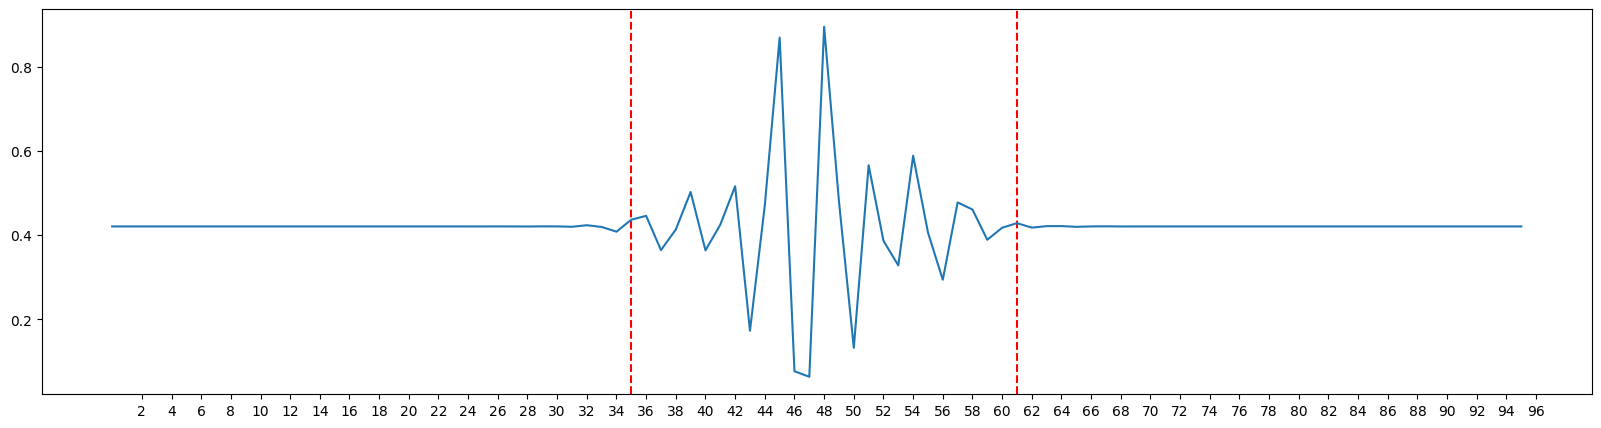

In [ ]:
# Let us check which is the most suitable radius for both gabors and MEIs
x = np.zeros(96)
for i in range(len(x)):
  x[i] = mean_gabors[29][i]

plt.figure(figsize = (20,5))
plt.axvline(x=35, color='red', ls='--')
plt.axvline(x=61, color='red', ls='--')
plt.xticks([i for i in range(1,97)if i%2==0])
plt.plot(x)

MEI: we notice it is a bit shifted to the right (approx 5 pixels)

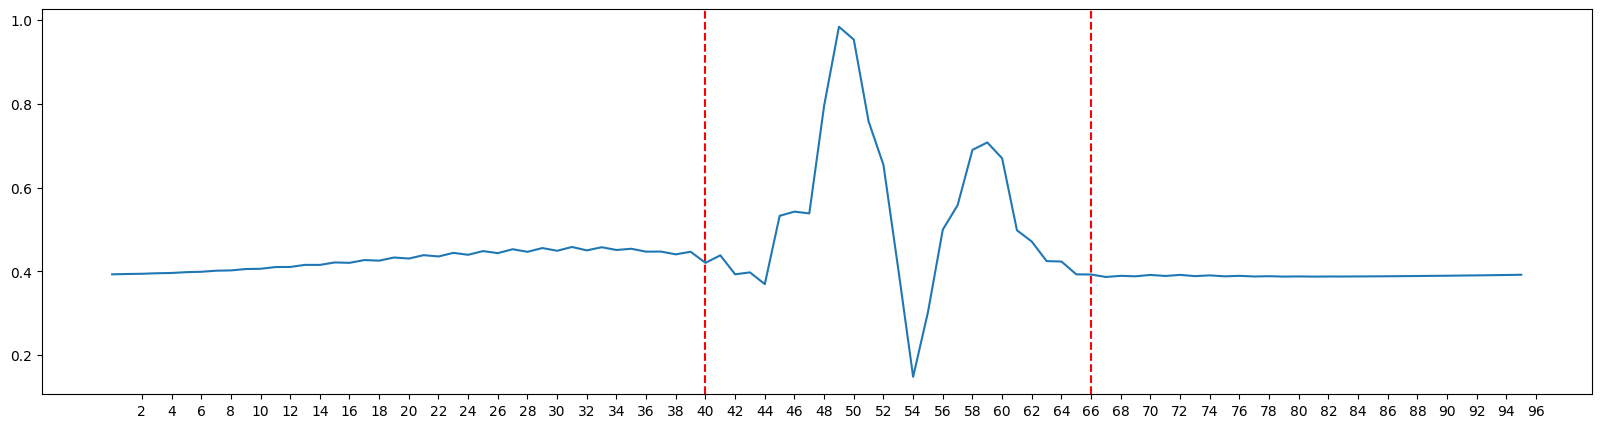

In [ ]:
x = np.zeros(96)
for i in range(len(x)):
  x[i] = final_mei[29][i]

plt.figure(figsize = (20,5))
plt.axvline(x=40, color='red', ls='--')
plt.axvline(x=66, color='red', ls='--')
plt.xticks([i for i in range(1,97)if i%2==0])
plt.plot(x)

We observe a symmetric behavior and, in order to consider the variability in pixel values we find on the edges of the circle, we extend the radius to 12.

In [ ]:
def create_circular_mask(h, w, center=None, radius=12):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

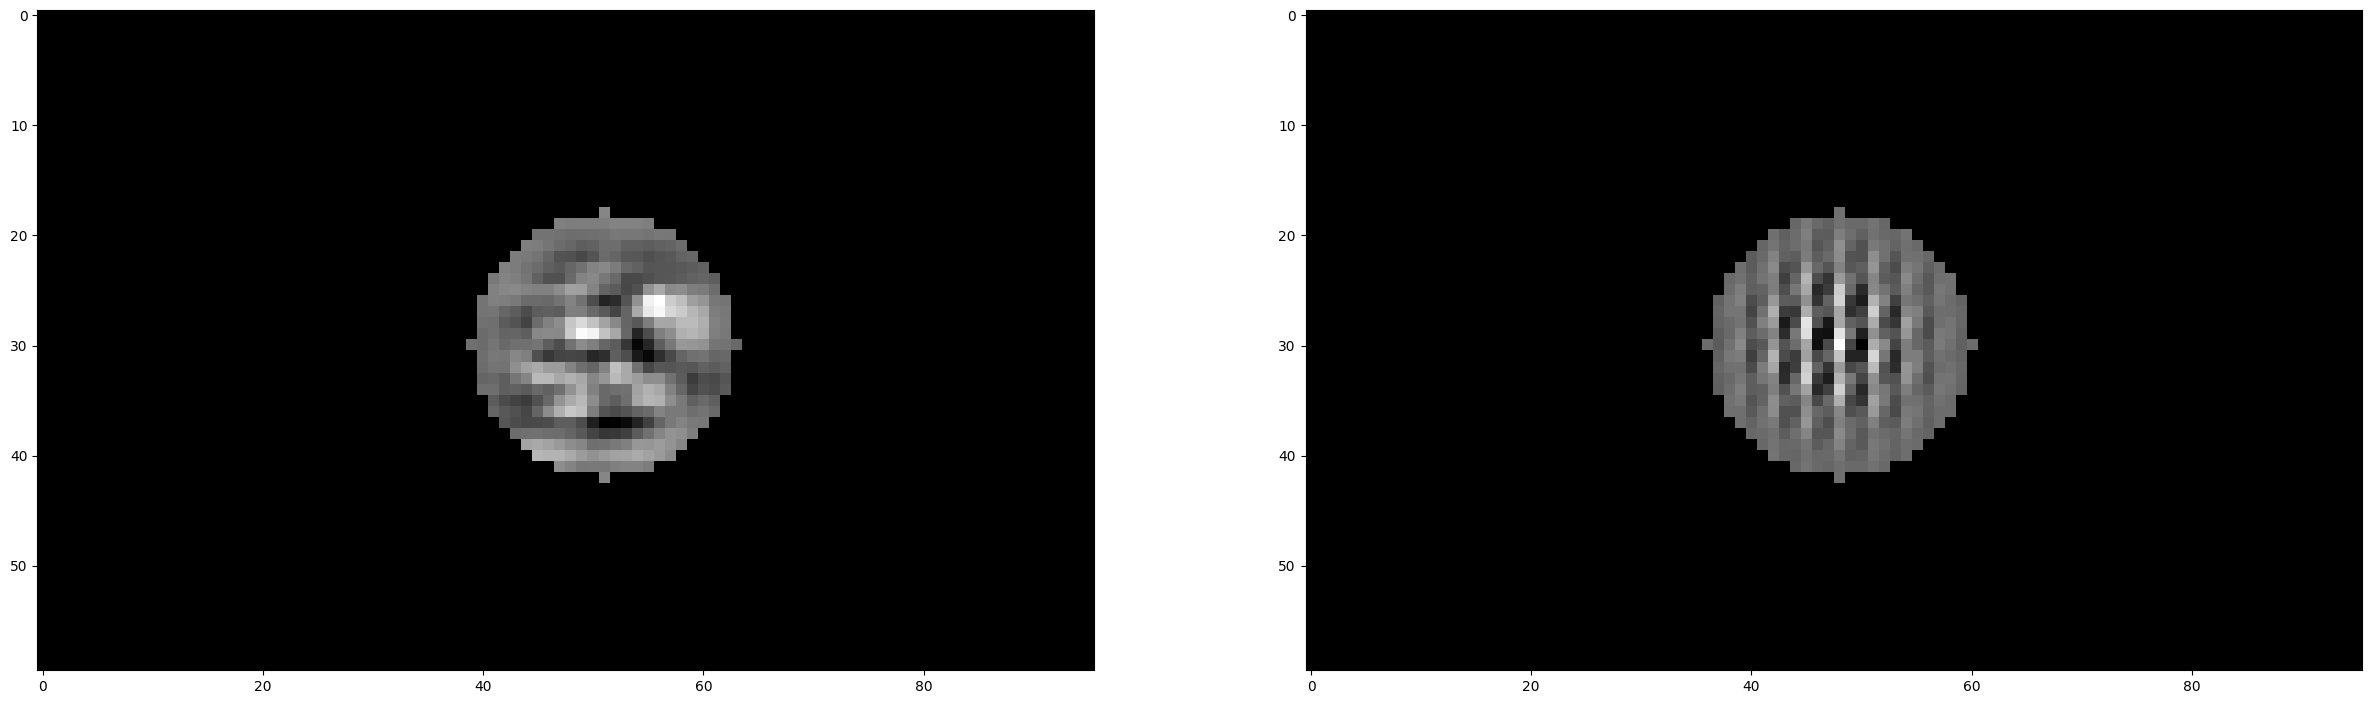

In [ ]:
masked_59, lum_59 = luminance(mei_59, radius=12, center=(int(mei_59.shape[1]/2+3), int(mei_59.shape[0]/2)))
masked_gab_59, lum_gab_59 = luminance(gabor_59, radius=12, center=None)

f, axarr = plt.subplots(1,2, figsize=(30,10))
axarr[0].imshow(masked_59, cmap='gray')
axarr[1].imshow(masked_gab_59, cmap = 'gray');

### **Luminance**
The luminance value was calculated as the average pixel intensity within the spatial mask:

In [ ]:
import math

def luminance(img, radius, center):
  # apply mask:
  h, w = img.shape[:2]
  themask = create_circular_mask(h,w, radius=radius, center=center)
  masked_img = img.copy()
  masked_img[~themask] = 0.0

  # compute luminance on masked img
  lum=0
  for x in masked_img:
    lum += x.sum()
  lum = lum / (math.pi*(radius**2))
  return masked_img, lum


In [ ]:
print(f'MEI luminance: {lum_59}')
print(f'Gabor luminance: {lum_gab_59}')

MEI luminance: 0.44963369290239985
Gabor luminance: 0.4097204913589961


From an initial visual inspection, the MEI appeared to exhibit higher luminance compared to the Gabor filter. However, when we delve into the metrics for a closer comparison, we find remarkable similarities between them. Notably, we observe that the luminance level that effectively activates the neuron is approximately $0.4$. This consistency across different visual tools underscores the specific luminance sensitivity of the neuron.

### **Contrast:**
Contrast is a crucial factor in how neurons process visual stimuli, significantly more so than merely the lightness or darkness of an image. We thus proceed with the same localized approach as before:

In [ ]:
print(f'C star: {c_star_std}')

C star: 0.2675706446170807


In [ ]:
def masked_contrast(image, mask):
    masked_values = image[mask]       #Apply mask to the image
    std_dev = np.std(masked_values)   #standard deviation
    return std_dev

In [ ]:
print("Standard deviation of non-masked MEI:", mei_59.std())
print("Standard deviation of non-masked Gabor:", gabor_59.std())

Standard deviation of non-masked MEI: 0.050091017
Standard deviation of non-masked Gabor: 0.03668658


In [ ]:
h, w = 60, 96
radius = 12

mask_mei_c = create_circular_mask(h, w, radius=radius, center= (int(w/2+3), int(h/2)))
masked_contrast_mei = masked_contrast(mei_59, mask_mei_c)
print("Masked Contrast MEI:", masked_contrast_mei)

mask_gab_c = create_circular_mask(h, w, radius=radius)
masked_contrast_gab = masked_contrast(gabor_59, mask_gab_c)
print("Masked Contrast Gabor:", masked_contrast_gab)

Masked Contrast MEI: 0.15114456
Masked Contrast Gabor: 0.13230467


We observe a significant difference betweeen the standard deviation of the unmasked image; moreover, we notice that the contrast values of masked images are very similar, and are not too far from the target contrast value $C^*$ identified as the mean contrast of our dataset.

### **Symmetry:**

Approach: \\
To calculate folio (1-fold) and quarto (2-fold) , we first performed FFT and averaged the power spectrum axially with bin size = $\frac{\pi}{16}$ radians. To calculate the axial average, we converted pixel Cartesian coordinates to polar coordinates, defining the center of the image as the origin (0,0). Pixels were then binned according to their angle, rounded down. Next, we defined an n-fold symmetry index (SI) as
$SI_n = \frac{|\sum_{\theta}P_{\theta}e^{i2n\theta}|}{\sum_\theta P_\theta}$
where $P_\theta$ is the average power at angle $\theta$ and the scalar multiplier 2 is due to the inherent point symmetry of the FFT power spectrum. SI is defined on the unit interval with 0 denoting a lack of symmetry and 1 being a fully n-fold symmetric image.

1. FFT: used to convert signals from the spatial or time domain into the frequency domain. This transformation provides a representation showing how much of each frequency exists in a signal or image. \\
The output of an FFT includes both amplitude, which indicates the strength or magnitude of each frequency component, and phase, which represents the orientation or initial angle of these frequency components.


2. Power Spectrum:  describes how much power, or variance, is carried by each frequency component of the signal or image. This measure is especially useful in identifying which frequencies contain the most energy, helping to analyze the signal's or image's overall texture or directional biases.

In [ ]:
# GABOR
fft_gab = fftshift(fft2(gabor_59))
pow_spec_gab = (np.abs(fft_gab))**2

freq_x = np.fft.fftshift(np.fft.fftfreq(gabor_59.shape[1])) * gabor_59.shape[1]
freq_y = np.fft.fftshift(np.fft.fftfreq(gabor_59.shape[0])) * gabor_59.shape[0]


# MEI
fft_mei = fftshift(fft2(mei_59))
pow_spec_mei = (np.abs(fft_mei))**2

freq_x_mei = np.fft.fftshift(np.fft.fftfreq(mei_59.shape[1])) * mei_59.shape[1]
freq_y_mei = np.fft.fftshift(np.fft.fftfreq(mei_59.shape[0])) * mei_59.shape[0]

3. Axial averaging with a bin size of $\frac{\pi}{16}$

In [ ]:
## function to compute axial average:
def axial_average(power, bin_size=1/16*np.pi):
    height, width = power.shape
    center = (int(width/2), int(height/2))
    Y, X = np.indices((height, width))

    #polar coordinates
    R = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    Theta = np.arctan2((Y - center[1]), (X - center[0]))
    theta_bins = np.floor(Theta / bin_size).astype(int)
    theta_bins += -theta_bins.min()  # Shift scale to be positive

    # Average by bins
    radial_sum = np.bincount(theta_bins.ravel(), weights=power.ravel())
    radial_count = np.bincount(theta_bins.ravel())
    radial_mean = radial_sum / radial_count
    return radial_mean, Theta, theta_bins

bin_size = 1/16*np.pi

In [ ]:
P_theta, Theta, theta_bins = axial_average(pow_spec_gab)
P_theta_mei, Theta_mei, theta_bins_mei = axial_average(pow_spec_mei)

Here the 1-fold and 2-fold symmetry index follows:

In [ ]:
def sym_index(P_theta, n):
    angles = np.arange(len(P_theta)) * bin_size
    ei2ntheta = np.exp(1j * 2 * n * angles)
    numerator = np.abs(np.sum(P_theta * ei2ntheta))
    denominator = np.sum(P_theta)
    return numerator / denominator

In [ ]:
# Calculate for 1-fold and 2-fold symmetry index
## GABOR
SI_1 = sym_index(P_theta, 1)
SI_2 = sym_index(P_theta, 2)
print("Gabor:")
print(f"1-Fold Symmetry Index: {SI_1}")
print(f"2-Fold Symmetry Index: {SI_2}\n")

## MEI
SI_1_mei = sym_index(P_theta_mei, 1)
SI_2_mei = sym_index(P_theta_mei, 2)
print("MEI:")
print(f"1-Fold Symmetry Index: {SI_1_mei}")
print(f"2-Fold Symmetry Index: {SI_2_mei}")

Gabor:
1-Fold Symmetry Index: 0.9992552829452915
2-Fold Symmetry Index: 0.9975716528845747

MEI:
1-Fold Symmetry Index: 0.9696106836897902
2-Fold Symmetry Index: 0.9845564551083268


### **Log Power Spectrum and Spatial Frequency Content:**
The power spectrum helps in visualizing the energy distribution across different frequencies without considering the phase information. This simplification can be particularly useful for analyzing the overall impact of various frequency components, such as distinguishing between high and low-frequency trends in the data.  \\

In image processing, the power spectrum is useful to reveal details about the texture and orientation of objects within the image, as certain concentrations of energy in specific frequency bands can indicate the presence of particular textures or alignments.

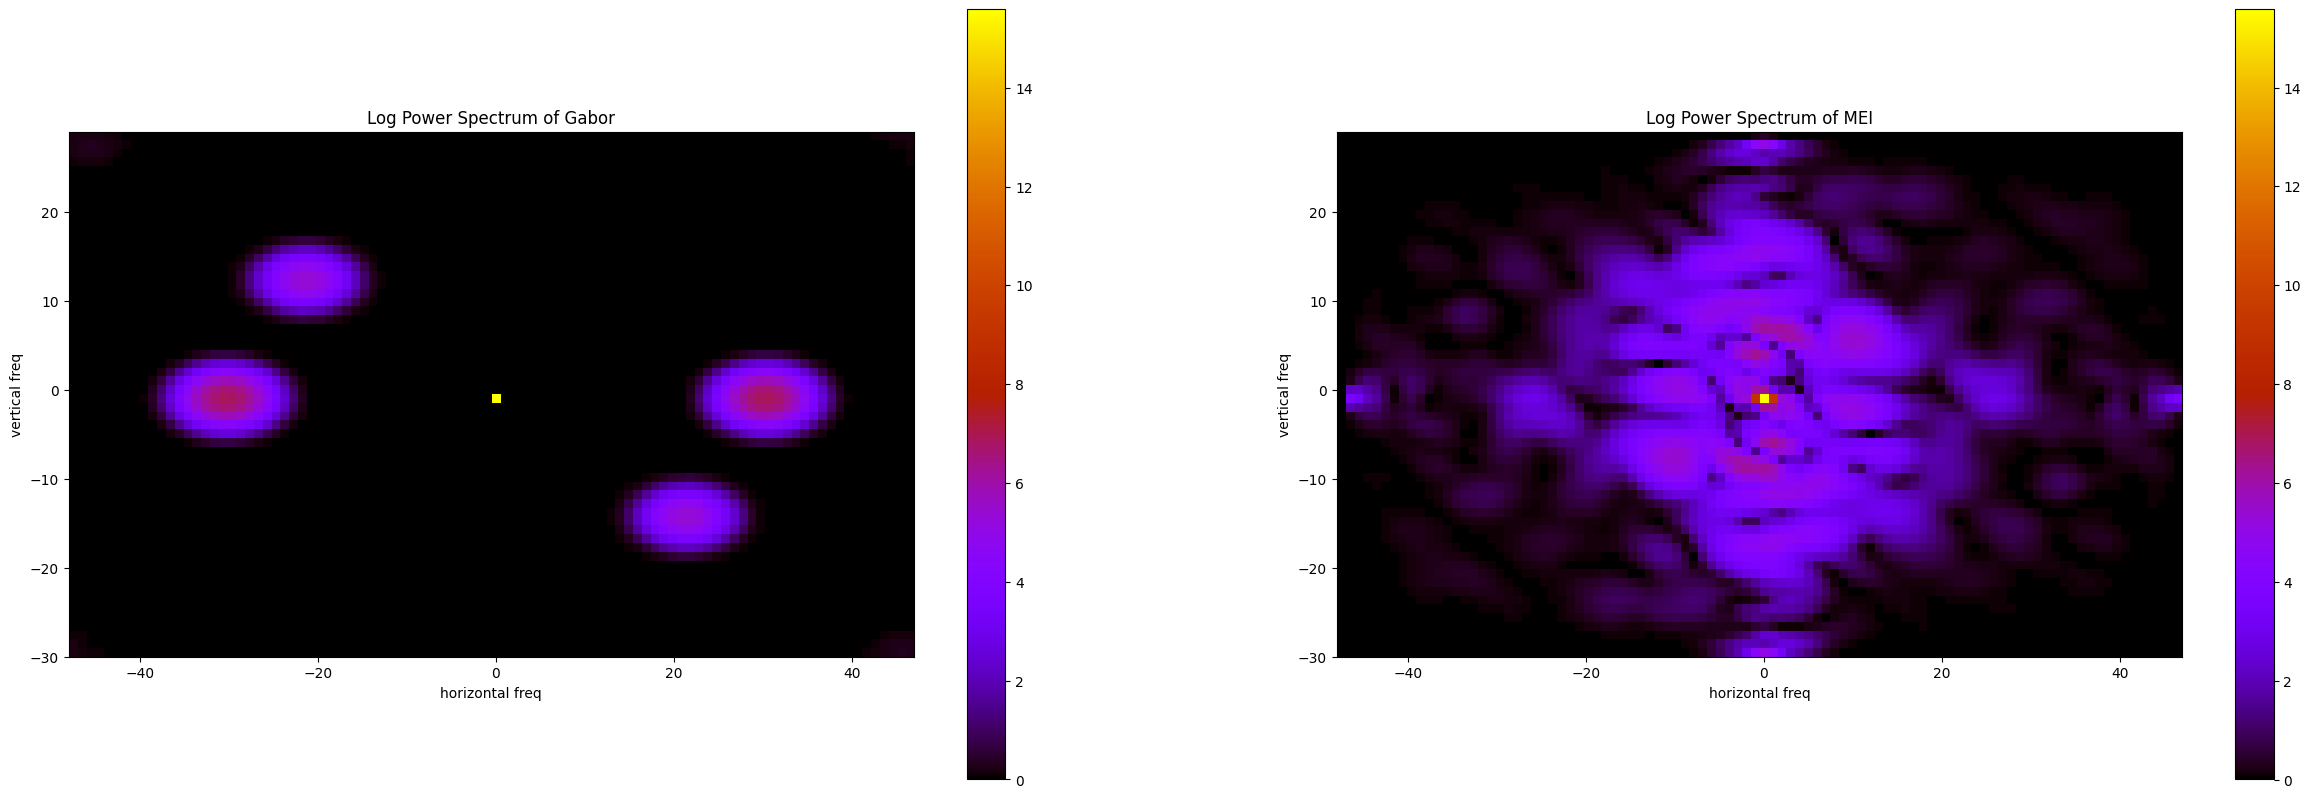

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(30,10))

im0 = axarr[0].imshow(np.log1p(pow_spec_gab), extent=[freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()], cmap='gnuplot')
f.colorbar(im0, ax=axarr[0])
axarr[0].set_title("Log Power Spectrum of Gabor")
axarr[0].set_xlabel('horizontal freq')
axarr[0].set_ylabel('vertical freq')

im1 = axarr[1].imshow(np.log1p(pow_spec_mei), extent=[freq_x_mei.min(), freq_x_mei.max(), freq_y_mei.min(), freq_y_mei.max()], cmap='gnuplot');
f.colorbar(im1, ax=axarr[1])
axarr[1].set_title("Log Power Spectrum of MEI")
axarr[1].set_xlabel('horizontal freq')
axarr[1].set_ylabel('vertical freq')
plt.show()

We can now make a few observations:

Firstly, the *zero frequency* point at the center of the plot, often
referred to as the DC (Direct Current) component in the context of Fourier analysis, represents the average or mean value of the entire image as it reflects the overall brightness or intensity.
We observe that, as it was expected, in both the MEI and the Gabor, the zero frequency component is significant, due to a large uniform area in the background that does not vary much in intensity. \\


While the Gabor's log power spectrum exhibits distinct peaks at high specific frequencies, the MEI's one displays a smooth, continuous distribution across the frequency range. \\

This behavior is consistent with the structural difference between the two generated images: Gabor filters are designed to respond maximally at their characteristic frequencies, typically associated with the specific orientation and scale of the sinusoidal wave, which corresponds to distinct edges in the visual stimuli. For this reason, it is meaningful to notice that they display a very focused frequency response, showing a peak response at their characteristic frequency. \\


In contrast, the dispersed frequency representation in the MEI's log power spectrum, with a significant contribution to the mid and low-frequency ranges, might suggest that the neuron is responsive to a broader variety of spatial frequencies, which aligns with processing less pronounced or smoother transitions in visual textures. \\

Such pattern could also be justified by the slight presence of noise, which generally contributes to a more random spread across frequencies. \\

Overall, since our MEI shows a more dispersed frequency representation, it could indicate that the neuron we examined responds not only to sharp, well-defined edges but also to edges with less contrast or those that are more diffusely defined. This can be a sign that the neuron processes information from a broader range of spatial frequencies.

# **Conclusions:**
Our analysis investigated the comparative efficacy of Most Excitatory Inputs (MEIs) and Gabor filters in maximizing neuronal responses for specific neurons. While MEIs are generally acknowledged as superior to Gabors, a direct comparison remains crucial for validating MEIs' specific advantages.
Additionally, we want to investigate whether MEIs, optimized for visual stimuli response, exhibit parallels with Gabors, designed to evoke maximal responses in V1 neurons of the visual cortex. Our inquiry aimed to uncover shared characteristics between the two.
Our findings reveal similarities between MEIs and Gabor patches, affirming the presence of common traits in driving neuronal response. Notably, research by Walker et al. (2019) suggests that MEIs elicit a heightened response compared to Gabor patches among V1 cortex neurons. However, it's essential to underscore that such analysis necessitates in vivo validation.

# **Limitations and Further Analysis:**
The limitations of our study stem from several factors:

1. **Small Dataset**: Both the number of recorded neurons and the quantity of natural images used for model training were limited. These limitations likely impacted the generalization capabilities of our model.

3. **Nature of Deep Neural Networks**: Deep neural networks often struggle to generalize beyond the typical statistics of their training data. Thus, it remains uncertain whether in silico synthesized MEIs can accurately predict in vivo responses, necessitating experimental verification of predictions derived from these models.

4. **Computational Resources and Time Constraints**: Resource limitations restricted the depth and breadth of our analysis, affecting both the complexity of our models and the scale of our simulations.

5. **Image Dimensions and Quality**: Due to limited computational resources, we resized the input images to expedite training, albeit at the expense of image quality. This compromise in image resolution hindered the model's ability to discern sharp edges and prominent patterns, thus impacting the learned characteristics of our model.

2. **Limited Gabor Details**: The parameter space for Gabor filters was constrained, primarily distinguishing only directions. With access to more diverse Gabors incorporating variations in phase, size, and eccentricity, we could have achieved a more precise comparison with our MEIs, thereby validating our analysis with greater accuracy.
Moving forward, further analysis could involve:

Further Analysis

- **Expansion Beyond VISam Neurons**: We focused exclusively on VISam neurons due to their prevalence in our available dataset, overlooking other areas of the visual cortex. Broadening our study to encompass neurons from diverse cortical regions could offer a more comprehensive insight into neuronal response patterns.
  
- **Exploration of Different Brain Regions**: While detailed insights may not be expected, examining brain regions beyond V1 could offer additional perspectives on neural response predictability.

- **Comparison with Alternative Stimuli**: Evaluating our model's performance against different types of stimuli could reveal its robustness and versatility.

- **Performance Comparison with Linear Models**: Contrasting the performance of our deep neural network with that of linear models could elucidate the advantages and limitations of each approach.

- **Extension to Multi-Neuron Prediction**: Expanding our CNN model to predict neuronal responses across multiple neurons simultaneously could enhance the sophistication and applicability of our simulations.


# **APPENDIX: Other Sampled Neurons**



In the following section, we will only show other examples of Most Excitatory Inputs and Gabor filters corresponding to other neurons we selected in the first section of our analysis. \\
In order to avoid repetitions, we decided to omit a detailed analysis for these neurons, as they are associated with a lower recorded accuracy value of the model used to predict their neuronal responses.

### **NEURON 951097919**, accuracy value: $46$%

In [ ]:
neuron_id = '951097919'

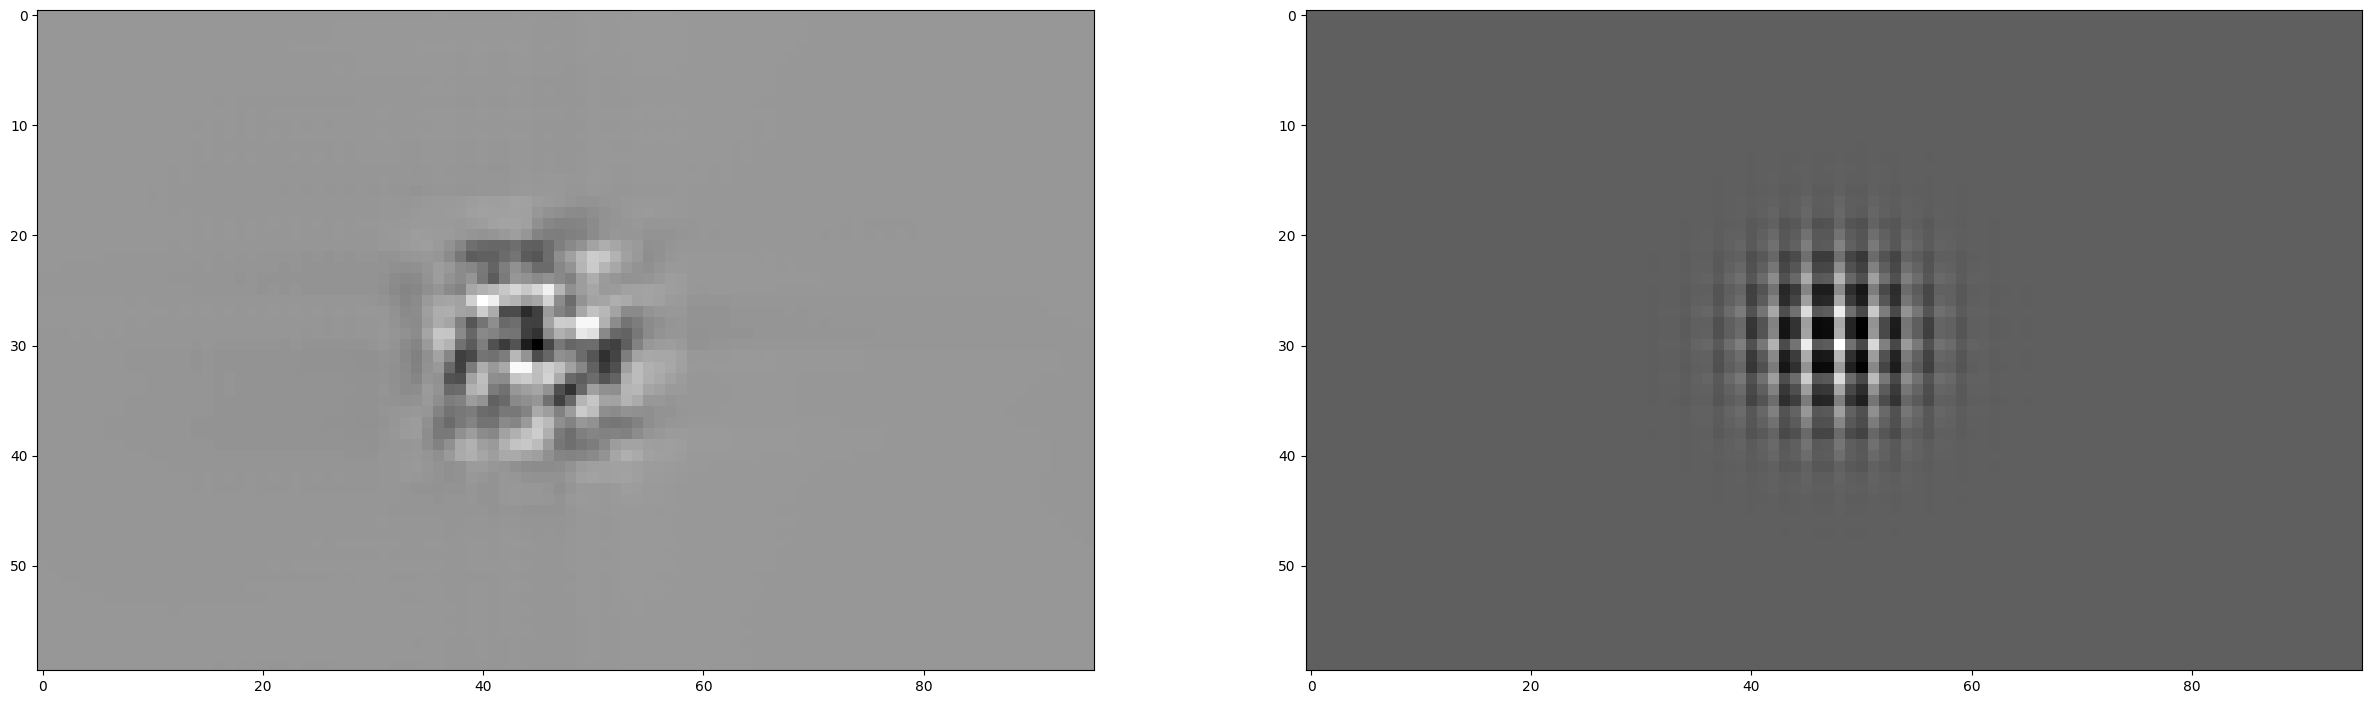

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(30,10))
axarr[0].imshow(mei_46, cmap='gray')
axarr[1].imshow(gabor_46, cmap = 'gray');

### NEURON **951092949**, accuracy value: $34$%

In [ ]:
neuron_id = '951092949'

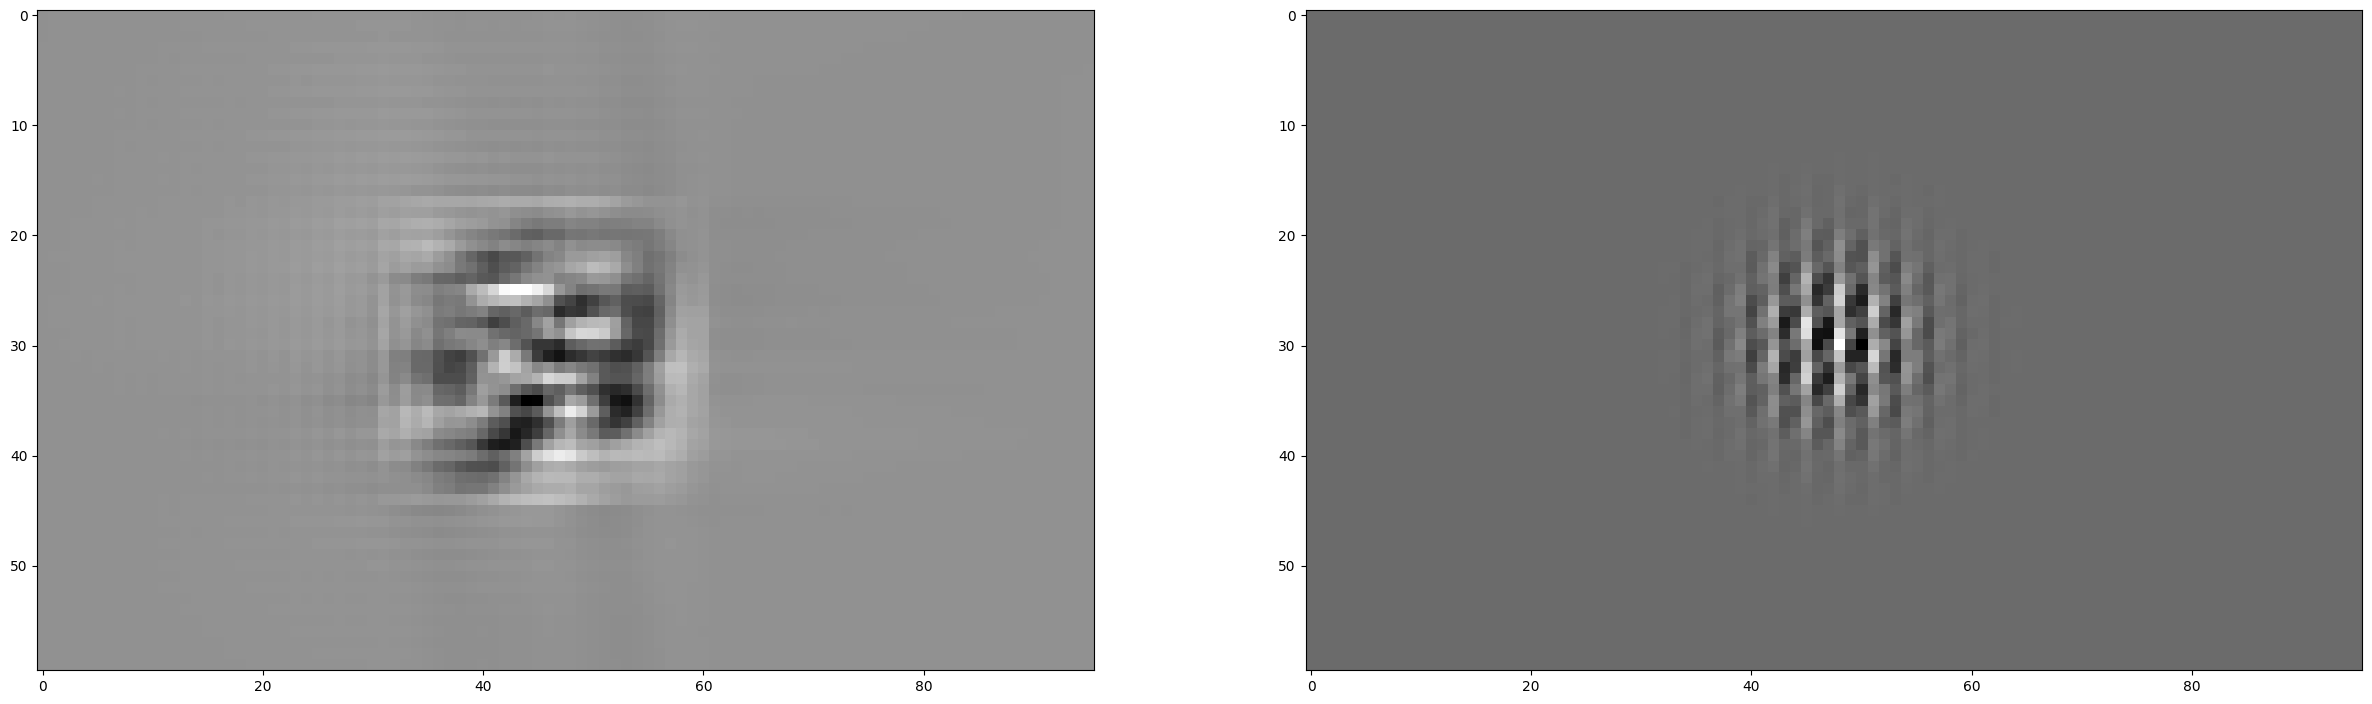

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(30,10))
axarr[0].imshow(mei_34, cmap='gray')
axarr[1].imshow(gabor_34, cmap = 'gray');

### **NEURON 951098928**, accuracy value: $32$%

In [ ]:
neuron_id = '951098928'

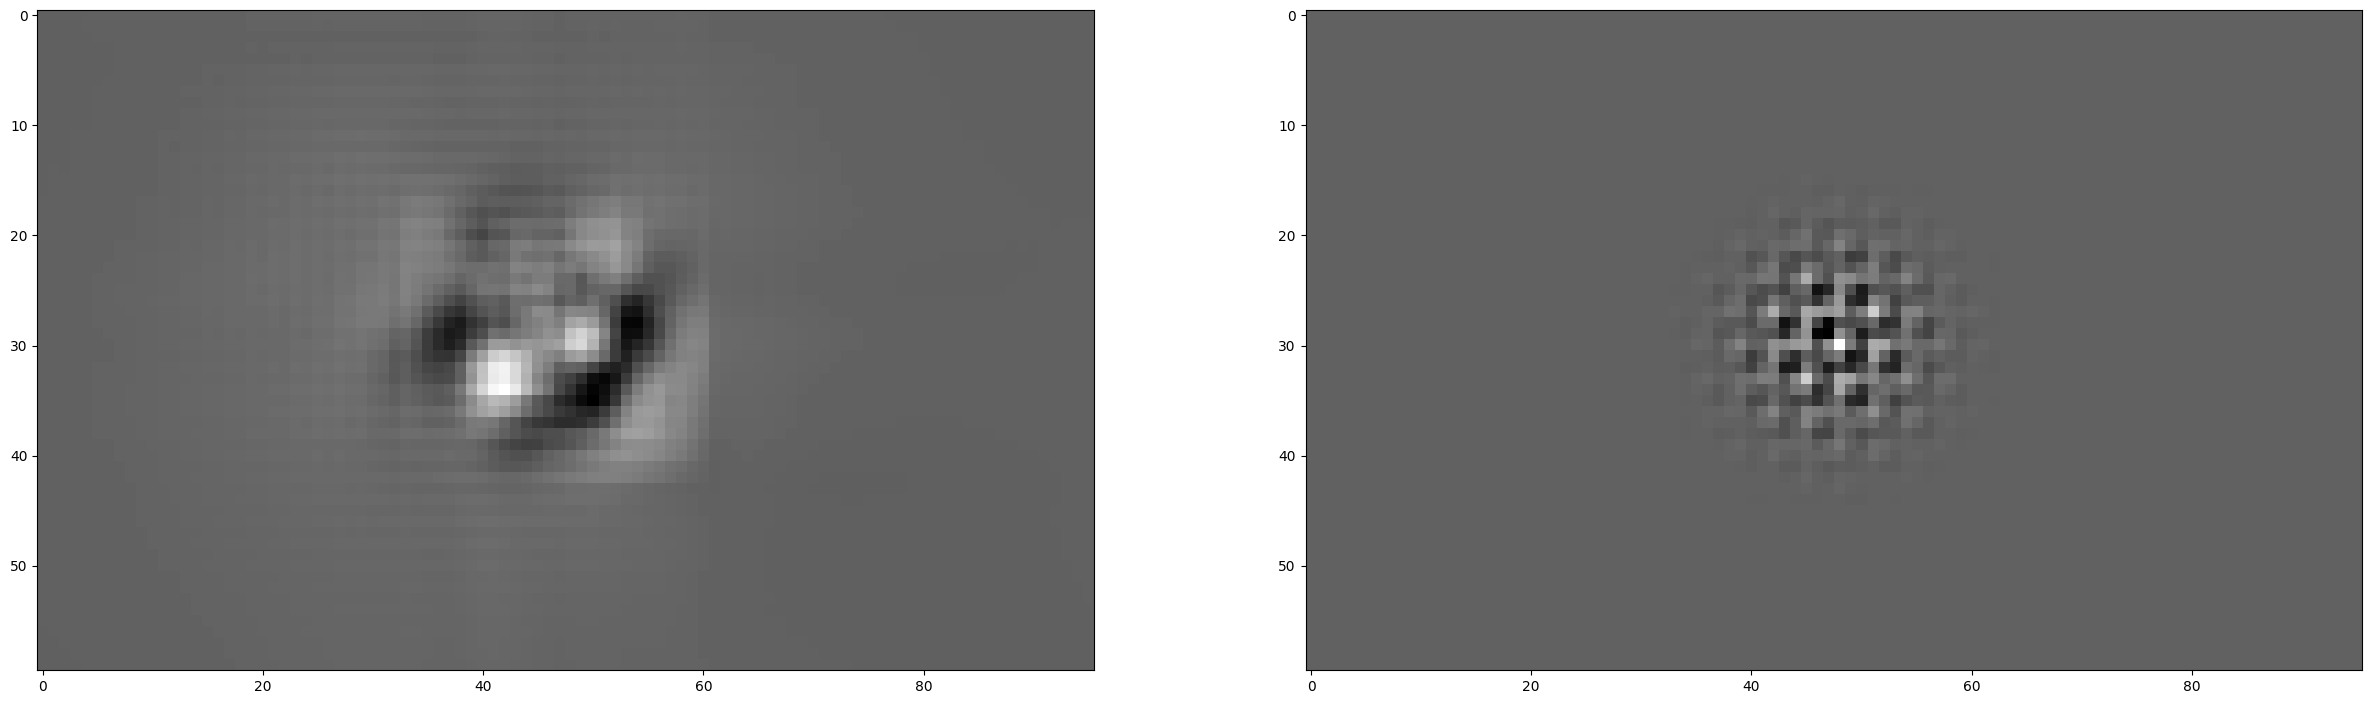

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(30,10))
axarr[0].imshow(mei_32, cmap='gray')
axarr[1].imshow(gabor_32, cmap = 'gray');